---
title: WER OMC
jupyter: python3
---

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import poisson, nbinom
from statsmodels.discrete.count_model import (
    ZeroInflatedNegativeBinomialP,
    ZeroInflatedPoisson,
)

# Einleitung
In diesem Projekt analysieren für das Jahr 2021 die Gewinnwahrscheinlichkeit aller NFL-Teams für die Spiele in Woche 15 der Saison. Die Berechnung basiert ausschliesslich auf den erzielten Punkten aus den ersten vierzehn Wochen.

Dabei splitten wir die Punktearten detailliert auf, um besser nachvollziehen zu koennen, wie die Punkte zustande gekommen sind. In der NFL gibt es verschiedene Möglichkeiten, Punkte zu erzielen: Ein Touchdown bringt 6 Punkte, ein erfolgreicher Extrapunkt im Anschluss 1 Punkt oder alternativ 2 Punkte bei einer Two-Point Conversion. Ein Field Goal zählt 3 Punkte, und ein Safety ergibt 2 Punkte.

Durch die Analyse der erzielten Punkte und ihrer Verteilung möchten wir untersuchen, ob sich daraus zuverlässige Aussagen über die Gewinnchancen eines Teams in Woche 15 ableiten lassen. Abschliessend vergleichen wir unsere berechneten Wahrscheinlichkeiten mit den tatsächlichen Spielergebnissen, um die Aussagekraft unseres Modells zu überprüfen.

## Fragestellung
**Wie hoch ist die Wahrscheinlichkeit, dass ein NFL-Team sein Spiel in Woche 15 gewinnt, basierend auf der Punktentwicklung aus den Wochen 1 bis und mit 14?**  
Dabei werden alle Teams der NFL betrachtet. Die berechneten Wahrscheinlichkeiten werden anschliessend mit den tatsächlichen Spielergebnissen aus Woche 15 verglichen, um die Aussagekraft des Modells zu überprüfen.

## Systemdefinition
Um die Gewinnwahrscheinlichkeit eines NFL-Teams in Woche 15 zu modellieren, betrachten wir ausschliesslich die Punkteverteilung aus Woche 1 bis und mit Woche 14. Das Systemverhalten ergibt sich aus der Annahme, dass die bisherige Punkteerzielung eines Teams, unabhängig davon, ob sie offensiv oder defensiv erzielt wurde, ein valider Indikator für die künftige Teamleistung ist.

Das Modell berücksichtigt sämtliche Punktearten, die ein Team im Verlauf eines Spiels erzielen kann. Dazu gehören offensiv erzeugte Punkte wie Touchdowns, Field Goals, Extrapunkte und Two-Point Conversions. Jegliche andere Punktearten werden zusammengefasst in *andere Punkte*. Darüber hinaus sind defensive Touchdowns, etwa durch Interception- oder Fumble-Returns, in der allgemeinen Touchdown-Zählung enthalten, auch wenn sie im Modell nicht separat ausgewiesen werden.

Nicht berücksichtigt werden hingegen externe Einflüsse wie Spielort (Home, Away), Verletzungen, defensive Stopp-Werte oder Turnover ohne direkten Punktgewinn, da diese den Rahmen von dieser Challenge sprengen würde. Der Fokus auf tatsächlich erzielte Punkte ist gerechtfertigt, da diese unmittelbar über den Spielausgang entscheiden und statistisch robust über die gesamte Saison hinweg vergleichbar sind. Sie bieten damit eine konsistente Grundlage für die Vorhersage von Gewinnwahrscheinlichkeiten.

Die getroffenen Annahmen ermöglichen eine realistische, datengetriebene Modellierung der Gewinnwahrscheinlichkeit auf Basis eines klar abgegrenzten, nachvollziehbaren Systems.

Die Modellgrenzen wurden bewusst definiert, um die Aussagekraft innerhalb eines klar umrissenen Analysebereichs zu maximieren.

## Daten säubern

## Aufbereitung des NFL-Datensatzes zur Analyse von Punktearten

Der Datensatz `nfl_data_all.csv` wurde eingelesen und bereinigt, um eine detaillierte Analyse der Punktverteilung in NFL-Spielen zu ermöglichen. Ziel war es, für jedes Spiel getrennt nach **Heim-** und **Auswärtsteam** folgende Punktearten zu erfassen:

- Anzahl **Touchdowns**
- Anzahl **Extrapunkte** (Point After Touchdown, PAT)
- Anzahl **Two-Point Conversions**
- Anzahl **Field Goals**
- Anzahl **sonstiger Punkte** (z. B. **Safetys**, derzeit nicht einzeln erfasst)

### Vorgehen

Die Berechnung erfolgte durch Filtern und Aggregieren der Spielzüge (`play_id`) nach `game_id` und teambezogenen Bedingungen. Für jede Punkteart wurde geprüft, ob das punktende Team das Heim- oder Auswärtsteam ist. Anschliessend wurden die berechneten Zählwerte ins Haupt-DataFrame gemergt.

Die aggregierten Zählspalten wurden am Ende des Prozesses pro Spiel zusammengefasst. So entstand ein vereinfachtes DataFrame mit einer Zeile pro Spiel.

### Punktearten im American Football

| Punkteart               | Punkte | Wann wird diese erzielt?                                                                 |
|-------------------------|--------|------------------------------------------------------------------------------------------|
| **Touchdown**           | 6      | Ein Spieler bringt den Ball in die gegnerische Endzone (durch Lauf oder Pass).          |
| **Extrapunkt (PAT)**    | 1      | Nach einem Touchdown: Erfolgreicher Kick durch die Torstangen.                          |
| **Two-Point Conversion**| 2      | Nach einem Touchdown: Statt Kick wird versucht, den Ball nochmals in die Endzone zu bringen. |
| **Field Goal**          | 3      | Erfolgreicher Kick durch die Torstangen während eines normalen Spielzugs (meist bei 4th Down). |
| **Safety**              | 2      | Wenn das angreifende Team in seiner eigenen Endzone gestoppt wird (nicht explizit aggregiert). |

### Resultierendes DataFrame

Das finale DataFrame enthält für jede `game_id` folgende Informationen:

- Spielinfos: `home_team`, `away_team`, `week`, `home_score`, `away_score`
- Punkteverteilung pro Team:
  - `home_team_touchdowns`, `away_team_touchdowns`
  - `home_team_EPs`, `away_team_EPs`
  - `home_team_TPs`, `away_team_TPs`
  - `home_team_FGs`, `away_team_FGs`

In [2]:
# Daten einlesen
df = pd.read_csv(r"./data/nfl_data_all.csv", low_memory=False)

# Relevante Spalten auswählen
df = df.loc[
    :,
    [
        "play_id",
        "game_id",
        "posteam",
        "home_team",
        "away_team",
        "week",
        "game_date",
        "field_goal_result",
        "extra_point_result",
        "two_point_conv_result",
        "td_team",
        "total_home_score",
        "total_away_score",
        "safety",
        "touchdown",
        "extra_point_attempt",
        "two_point_attempt",
        "field_goal_attempt",
        "away_score",
        "home_score",
    ],
]

# Touchdowns durch das Heimteam zählen
td_home = df[df["td_team"] == df["home_team"]]
td_counts = td_home.groupby("game_id").size().reset_index(name="home_team_touchdowns")
df = df.merge(td_counts, on="game_id", how="left")
df["home_team_touchdowns"] = df["home_team_touchdowns"].fillna(0).astype(int)

# Touchdowns durch das Auswärtsteam zählen
td_away = df[df["td_team"] == df["away_team"]]
td_away_counts = (
    td_away.groupby("game_id").size().reset_index(name="away_team_touchdowns")
)
df = df.merge(td_away_counts, on="game_id", how="left")
df["away_team_touchdowns"] = df["away_team_touchdowns"].fillna(0).astype(int)

# Field Goals durch das Heimteam zählen
fg_made_home = df[
    (df["field_goal_result"] == "made") & (df["posteam"] == df["home_team"])
]
fg_counts = fg_made_home.groupby("game_id").size().reset_index(name="home_team_FGs")
df = df.merge(fg_counts, on="game_id", how="left")
df["home_team_FGs"] = df["home_team_FGs"].fillna(0).astype(int)

# Field Goals durch das Auswärtsteam zählen
fg_made_away = df[
    (df["field_goal_result"] == "made") & (df["posteam"] == df["away_team"])
]
fg_counts = fg_made_away.groupby("game_id").size().reset_index(name="away_team_FGs")
df = df.merge(fg_counts, on="game_id", how="left")
df["away_team_FGs"] = df["away_team_FGs"].fillna(0).astype(int)

# Extrapunkte (PATs) durch das Heimteam zählen
ep_good_home = df[
    (df["extra_point_result"] == "good") & (df["posteam"] == df["home_team"])
]
ep_counts = ep_good_home.groupby("game_id").size().reset_index(name="home_team_EPs")
df = df.merge(ep_counts, on="game_id", how="left")
df["home_team_EPs"] = df["home_team_EPs"].fillna(0).astype(int)

# Extrapunkte durch das Auswärtsteam zählen
ep_good_away = df[
    (df["extra_point_result"] == "good") & (df["posteam"] == df["away_team"])
]
ep_counts = ep_good_away.groupby("game_id").size().reset_index(name="away_team_EPs")
df = df.merge(ep_counts, on="game_id", how="left")
df["away_team_EPs"] = df["away_team_EPs"].fillna(0).astype(int)

# Two-Point Conversions durch das Heimteam zählen
tp_good_home = df[
    (df["two_point_conv_result"] == "success") & (df["posteam"] == df["home_team"])
]
tp_counts = tp_good_home.groupby("game_id").size().reset_index(name="home_team_TPs")
df = df.merge(tp_counts, on="game_id", how="left")
df["home_team_TPs"] = df["home_team_TPs"].fillna(0).astype(int)

# Two-Point Conversions durch das Auswärtsteam zählen
tp_good_away = df[
    (df["two_point_conv_result"] == "success") & (df["posteam"] == df["away_team"])
]
tp_counts = tp_good_away.groupby("game_id").size().reset_index(name="away_team_TPs")
df = df.merge(tp_counts, on="game_id", how="left")
df["away_team_TPs"] = df["away_team_TPs"].fillna(0).astype(int)

# Aggregation auf Spielebene
df = (
    df.groupby(["game_id"])
    .agg(
        home_team=("home_team", "first"),
        away_team=("away_team", "first"),
        week=("week", "first"),
        away_score=("away_score", "first"),
        home_score=("home_score", "first"),
        home_team_touchdowns=("home_team_touchdowns", "first"),
        away_team_touchdowns=("away_team_touchdowns", "first"),
        home_team_FGs=("home_team_FGs", "first"),
        away_team_FGs=("away_team_FGs", "first"),
        home_team_EPs=("home_team_EPs", "first"),
        away_team_EPs=("away_team_EPs", "first"),
        home_team_TPs=("home_team_TPs", "first"),
        away_team_TPs=("away_team_TPs", "first"),
    )
    .reset_index()
)

df.head()

filtered_df = df[df["game_id"].str.contains("ARI|DET", na=False)]
filtered_df

,game_id,home_team,away_team,week,away_score,home_score,home_team_touchdowns,away_team_touchdowns,home_team_FGs,away_team_FGs,home_team_EPs,away_team_EPs,home_team_TPs,away_team_TPs
0,2021_01_ARI_TEN,TEN,ARI,1,38,13,2,5,0,1,1,5,0,0
15,2021_01_SF_DET,DET,SF,1,41,33,4,5,1,2,2,5,2,0
21,2021_02_DET_GB,GB,DET,2,17,35,5,2,0,1,5,2,0,0
26,2021_02_MIN_ARI,ARI,MIN,2,33,34,4,4,2,2,4,3,0,0
32,2021_03_ARI_JAX,JAX,ARI,3,31,19,3,4,0,1,1,4,0,0
34,2021_03_BAL_DET,DET,BAL,3,19,17,2,1,1,4,2,1,0,0
48,2021_04_ARI_LA,LA,ARI,4,37,20,2,4,2,3,2,4,0,0
52,2021_04_DET_CHI,CHI,DET,4,14,24,3,2,1,0,3,2,0,0
68,2021_05_DET_MIN,MIN,DET,5,17,19,1,1,4,3,1,0,0,1
78,2021_05_SF_ARI,ARI,SF,5,10,17,2,1,1,1,2,1,0,0


1. **`df_team_week`**
- **Struktur**: Aggregierte Statistiken **pro Team und Spielwoche**.  
- **Spalten**:  
  - `team`: Teamname (zuvor als Home/Away-Team getrennt).  
  - `week`: Spielwoche.  
  - `touchdowns`: Gesamte Touchdowns des Teams in der Woche.  
  - `pats`: Erfolgreiche PATs (Extra Points nach Touchdowns).  
  - `two_point_conversions`: Erfolgreiche Two-Point Conversions.  
  - `field_goals`: Erfolgreiche Field Goals.  
  - `other_scores`: Sonstige Punkte (z. B. Safeties), berechnet als `total_points - (Touchdowns + PATs + Two-Point Conversions + Field Goals)`.  
  - `total_points`: Gesamtpunkte des Teams in der Woche.  
- **Sortierung**: Nach `team` und `week` aufsteigend.  

2. **`df_till_w14`**  
- **Inhalt**: Alle Spiele aus **Woche 1 bis einschliesslich Woche 14** (gefiltert aus `df_team_week`).  
- **Zweck**: Dient als Basis für Analysen der regulären Saison (z. B. Trends, Team-Performance vor Woche 15).  

3. **`df_w15`**  
- **Inhalt**: Nur Spiele aus **Woche 15** (gefiltert aus `df_team_week`).  
- **Zweck**: Ermöglicht gezielte Auswertungen für diese Woche (z. B. Vorhersagemodelle, Vergleich mit früheren Wochen).  

In [3]:
# Daten des Heimteams aufbereiten
df_home = df[
    [
        "home_team",
        "week",
        "home_team_touchdowns",
        "home_team_EPs",
        "home_team_TPs",
        "home_team_FGs",
        "home_score",
    ]
].rename(
    columns={
        "home_team": "team",
        "home_team_touchdowns": "touchdowns",
        "home_team_EPs": "pats",
        "home_team_TPs": "two_point_conversions",
        "home_team_FGs": "field_goals",
        "home_score": "score",
    }
)

# Daten des Auswärtsteams aufbereiten
df_away = df[
    [
        "away_team",
        "week",
        "away_team_touchdowns",
        "away_team_EPs",
        "away_team_TPs",
        "away_team_FGs",
        "away_score",
    ]
].rename(
    columns={
        "away_team": "team",
        "away_team_touchdowns": "touchdowns",
        "away_team_EPs": "pats",
        "away_team_TPs": "two_point_conversions",
        "away_team_FGs": "field_goals",
        "away_score": "score",
    }
)

# Heim- und Auswärtsdaten zusammenführen
df_team_week = pd.concat([df_home, df_away], axis=0)

# Erwartete Punkte basierend auf Scoring-Aktionen berechnen
df_team_week["total_scored_points"] = (
    df_team_week["touchdowns"] * 6
    + df_team_week["pats"] * 1
    + df_team_week["two_point_conversions"] * 2
    + df_team_week["field_goals"] * 3
)

# Differenz zu den tatsächlichen Punkten ergibt sonstige Punkte (z.B. Safetys)
df_team_week["other_scores"] = (
    df_team_week["score"] - df_team_week["total_scored_points"]
)

# Aggregation auf Team-Wochen-Ebene und Umbenennung der Punktespalte
df_team_week = (
    df_team_week.groupby(["team", "week"], as_index=False)
    .agg(
        {
            "touchdowns": "sum",
            "pats": "sum",
            "two_point_conversions": "sum",
            "field_goals": "sum",
            "other_scores": "sum",
            "score": "sum",
        }
    )
    .rename(columns={"score": "total_points"})
    .sort_values(["team", "week"])
    .reset_index(drop=True)
)

# Spiele bis einschliesslich Woche 14
df_till_w14 = df_team_week[df_team_week["week"] <= 14].copy()

# Spiele aus Woche 15
df_w15 = df[df["week"] == 15].copy()

# Explorative Datenanalyse (EDA)
- touchdowns pro Woche pro Team
- Field Goals pro Woche pro Team
- Und Rest pro Woche pro Team

## Univariate Analyse

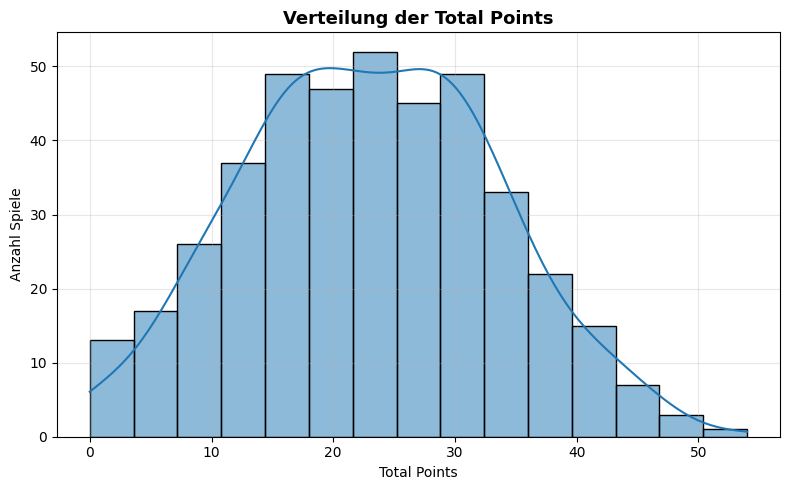

In [4]:
plt.figure(figsize=(8, 5))
sns.histplot(df_till_w14["total_points"], bins=15, kde=True)
plt.title("Verteilung der Total Points", fontsize=13, fontweight="bold")
plt.xlabel("Total Points")
plt.ylabel("Anzahl Spiele")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Der Plot zeigt die Verteilung der erzielten Gesamtpunkte der ersten 14 Wochen. Die Werte folgen einer annähernd normalverteilten Kurve mit einem Schwerpunkt im Bereich zwischen 20 und 30 Punkten.

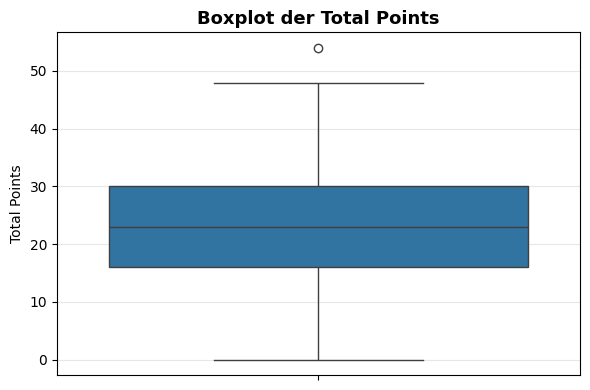

In [5]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_till_w14["total_points"])
plt.title("Boxplot der Total Points", fontsize=13, fontweight="bold")
plt.ylabel("Total Points")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Der Boxplot zeigt die Verteilung der Gesamtpunkte mit einem Median von etwa 23 Punkten. Die meisten Werte liegen zwischen ca. 16 und 30 Punkten, wobei ein einzelner Ausreisser über 50 Punkten liegt.

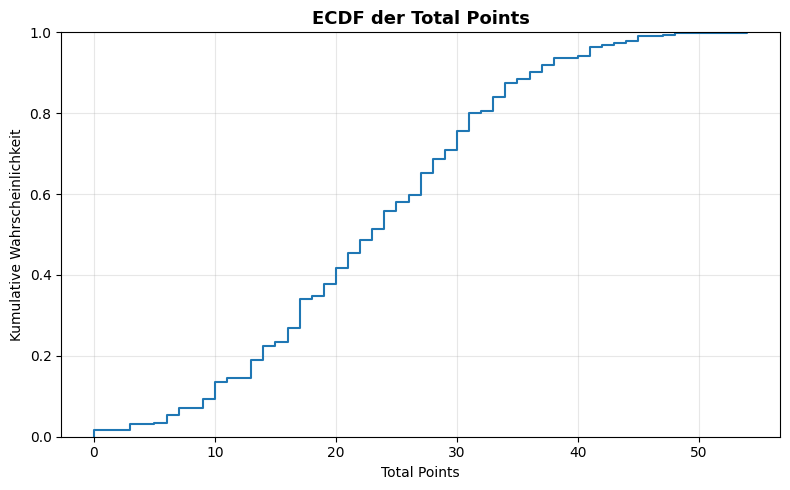

In [6]:
plt.figure(figsize=(8, 5))
sns.ecdfplot(df_till_w14["total_points"])
plt.title("ECDF der Total Points", fontsize=13, fontweight="bold")
plt.xlabel("Total Points")
plt.ylabel("Kumulative Wahrscheinlichkeit")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Die empirische Verteilungsfunktion (ECDF) zeigt, dass etwa 80 % der Spiele weniger als ca 32 Punkte erzielen. Der Anstieg in der Mitte der Kurve bestätigt die Konzentration der Werte im Bereich zwischen 20 und 30 Punkten.

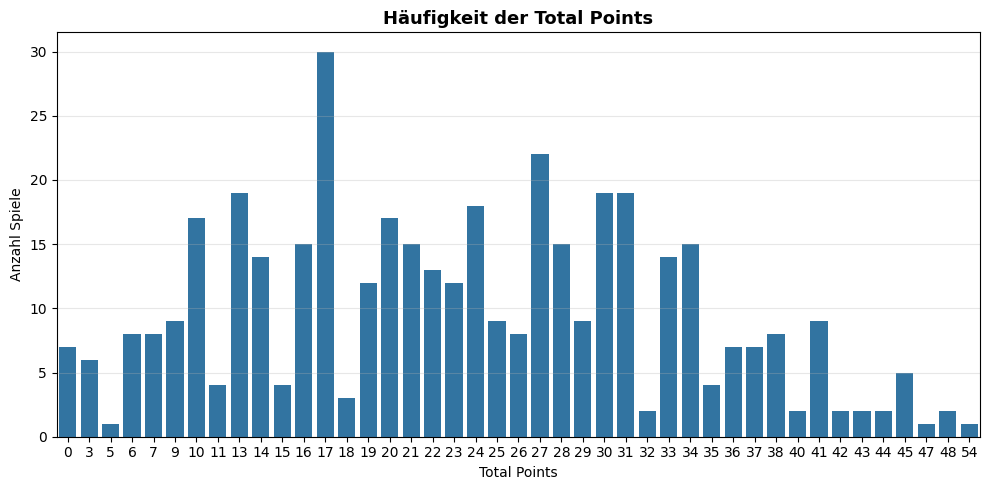

In [7]:
plt.figure(figsize=(10, 5))
sns.countplot(x="total_points", data=df_till_w14)
plt.title("Häufigkeit der Total Points", fontsize=13, fontweight="bold")
plt.xlabel("Total Points")
plt.ylabel("Anzahl Spiele")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Die Häufigkeitsverteilung der Gesamtpunkte zeigt, dass bestimmte Punktzahlen, wie z. B. 17 und 27 besonders häufig vorkommen. Insgesamt verteilt sich die Punktzahl relativ gleichmässig über einen Bereich von 0 bis etwa 45, mit wenigen Extremwerten darüber hinaus. Der Grund für die Häufung bestimmter Punktzahlen könnte auf strategische Spielzüge oder häufige Spielereignisse zurückzuführen sein, die zu diesen Punktzahlen führen. Zum Beispiel könnten 17 Punkte häufig durch eine Kombination aus Touchdowns, Field Goals und PATs erzielt werden. 

In [8]:
df_till_w14.head()

,team,week,touchdowns,pats,two_point_conversions,field_goals,other_scores,total_points
0,ARI,1,5,5,0,1,0,38
1,ARI,2,4,4,0,2,0,34
2,ARI,3,4,4,0,1,0,31
3,ARI,4,4,4,0,3,0,37
4,ARI,5,2,2,0,1,0,17


In [9]:
df_till_w14.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416 entries, 0 to 565
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   team                   416 non-null    object
 1   week                   416 non-null    int64 
 2   touchdowns             416 non-null    int64 
 3   pats                   416 non-null    int64 
 4   two_point_conversions  416 non-null    int64 
 5   field_goals            416 non-null    int64 
 6   other_scores           416 non-null    int64 
 7   total_points           416 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 29.2+ KB


In [10]:
df_till_w14.describe()

df_till_w14

,team,week,touchdowns,pats,two_point_conversions,field_goals,other_scores,total_points
0,ARI,1,5,5,0,1,0,38
1,ARI,2,4,4,0,2,0,34
2,ARI,3,4,4,0,1,0,31
3,ARI,4,4,4,0,3,0,37
4,ARI,5,2,2,0,1,0,17
...,...,...,...,...,...,...,...,...
561,WAS,10,3,2,0,3,0,29
562,WAS,11,3,3,0,2,0,27
563,WAS,12,2,0,1,1,0,17
564,WAS,13,2,2,0,1,0,17


## Bivariate Analyse

### Für 3 isolierte Teams

Für die Visualisierung der Häufigkeit der Features werden 3 beispiel Teams verwendet:
- **Team 1**: Minnesota Vikings
- **Team 2**: Miami Dolphins
- **Team 3**: Los Angeles Rams

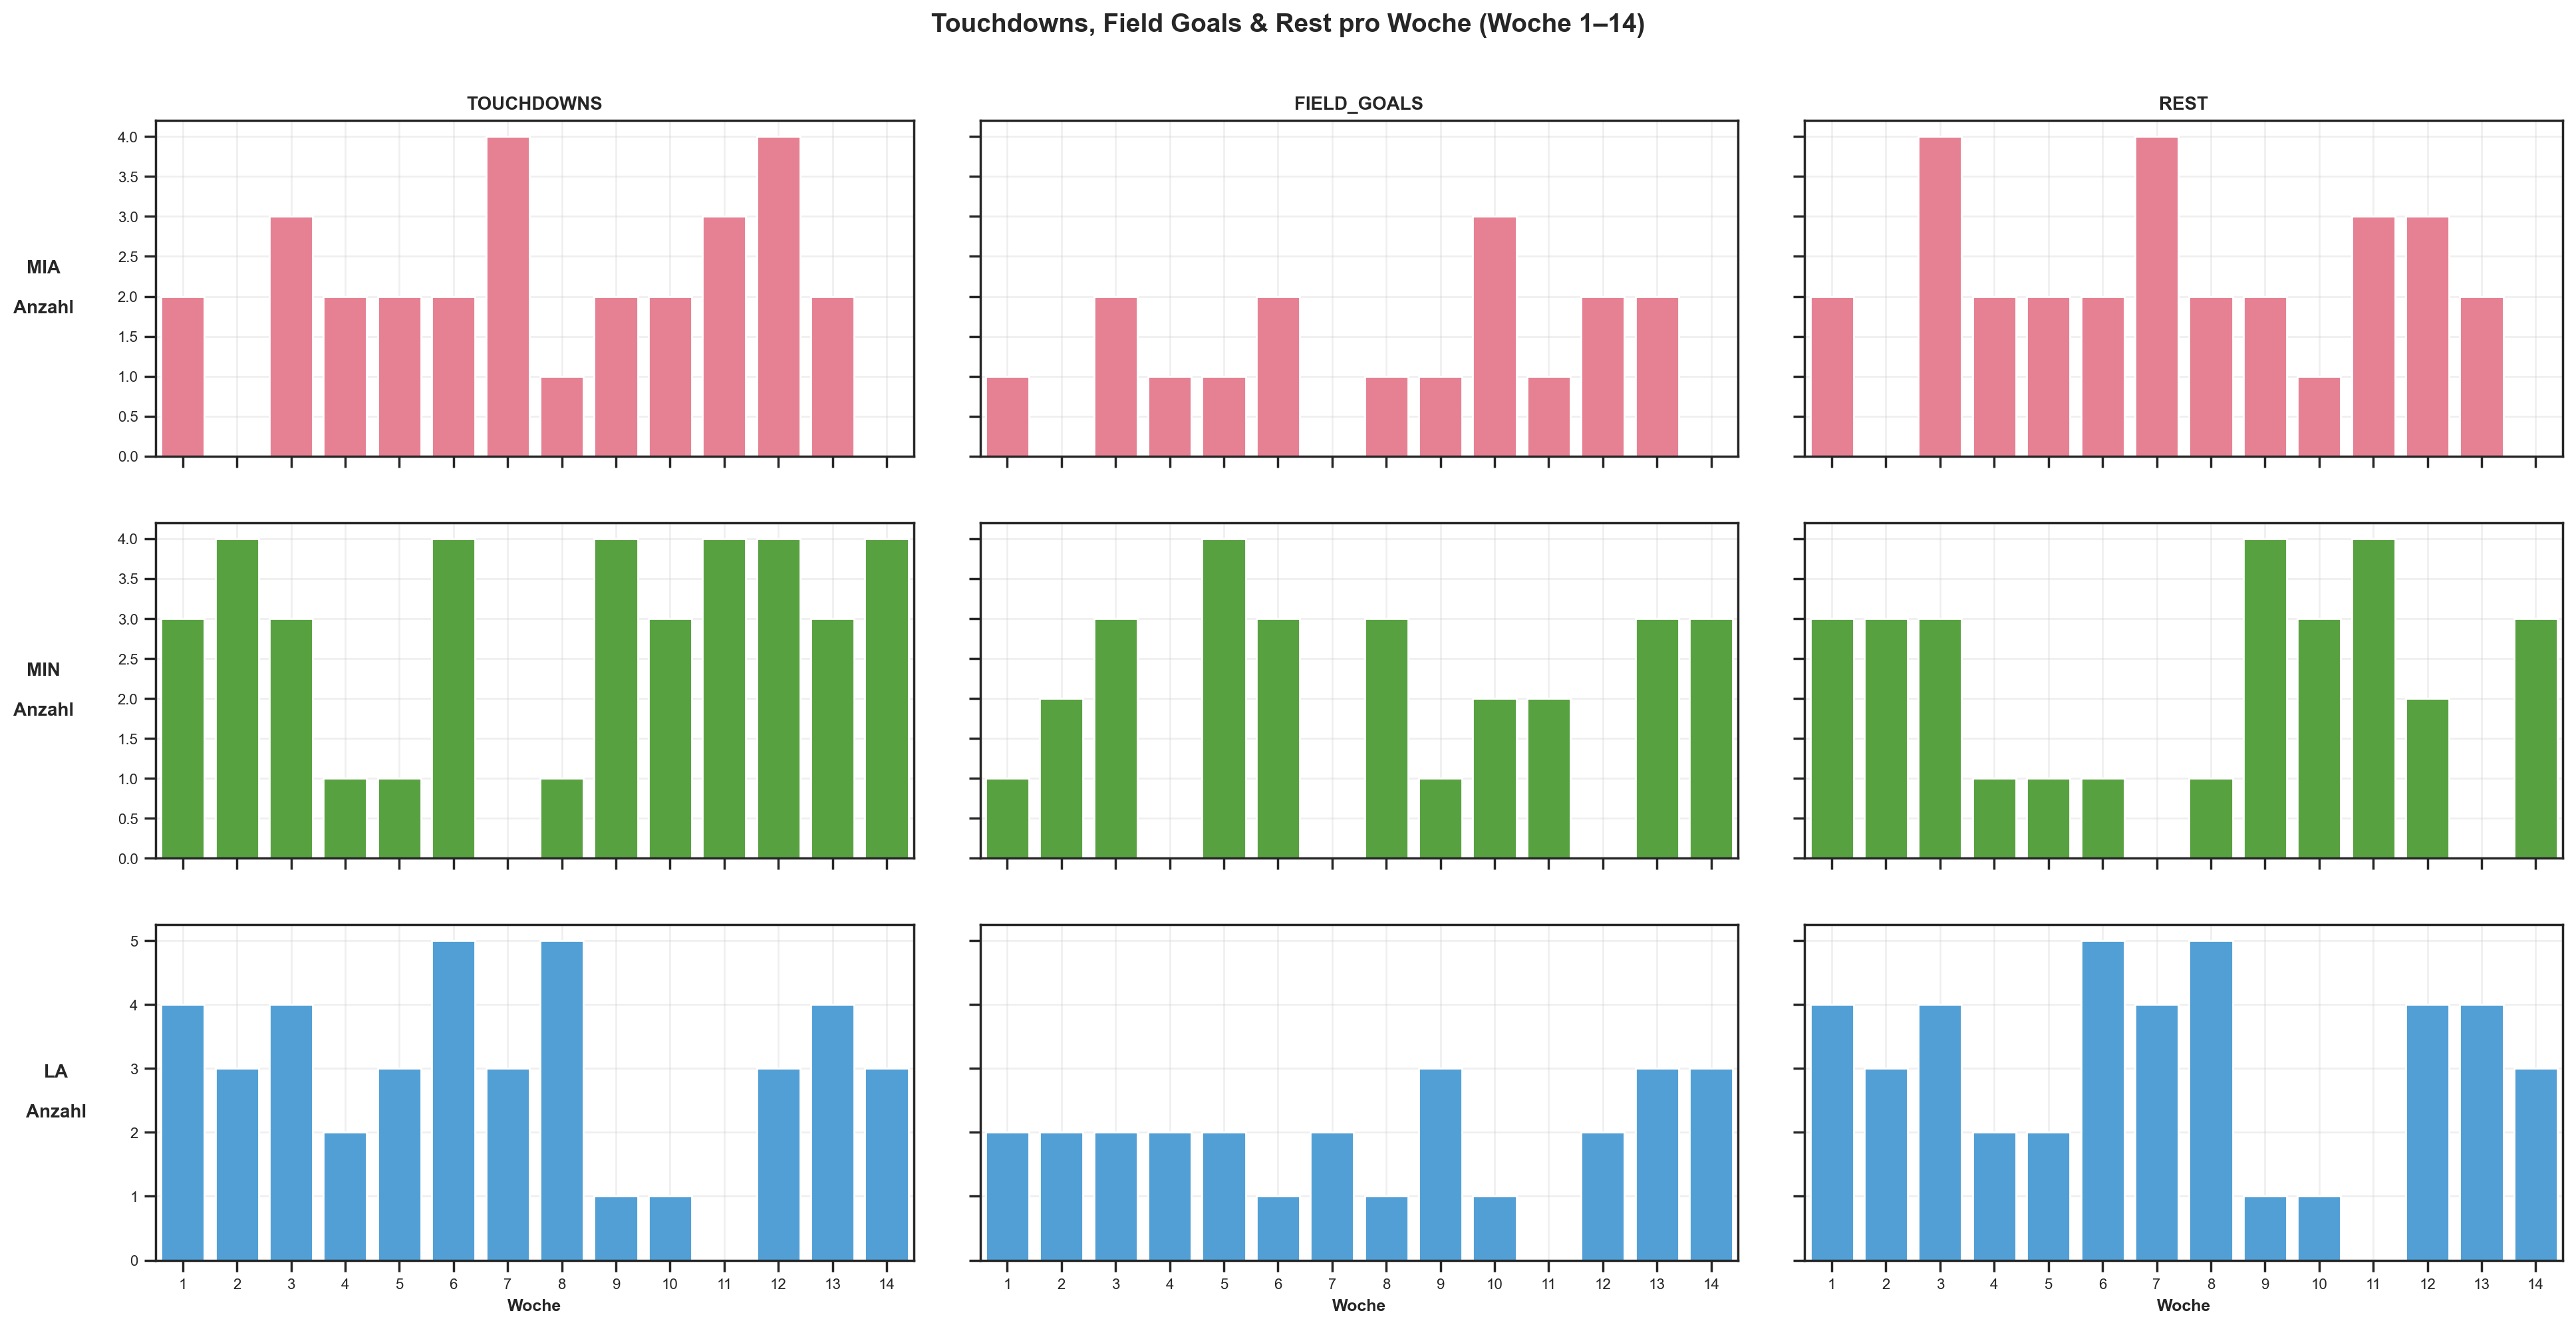

In [11]:
# Höhere Auflösung für Diagramme im Notebook
%config InlineBackend.figure_format = 'retina'

# Seaborn-Stil aktivieren
sns.set_theme(style="ticks", palette="pastel")

# Ausgewählte Teams und zu analysierende Metriken
selected_teams = ['MIA', 'MIN', 'LA']
features = ['touchdowns', 'field_goals', 'rest']

# Restpunkte berechnen (z. B. durch Safeties oder andere Ereignisse)
df_till_w14['rest'] = df_till_w14['total_points'] - (
    df_till_w14['touchdowns'] * 6 + df_till_w14['field_goals'] * 3
)

# Subplot-Grundgerüst anlegen
fig, axes = plt.subplots(len(selected_teams), len(features), 
                         figsize=(20, 10), 
                         sharex='col', 
                         sharey='row')

# Farbpalette für die Teams
palette = sns.color_palette("husl", n_colors=len(selected_teams))

# Schleifen für Team- und Feature-Plotting
for row_idx, team in enumerate(selected_teams):
    team_data = df_till_w14[df_till_w14['team'] == team]
    
    for col_idx, feature in enumerate(features):
        ax = axes[row_idx, col_idx]

        # Balkendiagramm: jeweiliges Feature über die Wochen
        sns.barplot(
            data=team_data,
            x='week',
            y=feature,
            ax=ax,
            color=palette[row_idx]
        )

        # Spaltentitel in oberster Zeile
        if row_idx == 0:
            ax.set_title(f"{feature.upper()}", fontsize=10, fontweight='bold')

        # Linke Spalte: Teamname als y-Achsentitel
        if col_idx == 0:
            ax.set_ylabel(f"{team}\n\nAnzahl", fontsize=10, fontweight='bold',
                          rotation=0, labelpad=40, va='center')
        else:
            ax.set_ylabel("")

        # Nur unterste Reihe zeigt x-Achsenbeschriftung
        if row_idx == len(selected_teams) - 1:
            ax.set_xlabel("Woche", fontsize=9, fontweight="bold")
        else:
            ax.set_xlabel("")

        ax.tick_params(axis='both', labelsize=8)
        ax.grid(True, alpha=0.3)

# Gesamttitel und Layout optimieren
plt.tight_layout(pad=2.5)
plt.suptitle("Touchdowns, Field Goals & Rest pro Woche (Woche 1–14)", 
             y=1.02, fontsize=14, fontweight='bold')
plt.show()

Die Grafik zeigt die wöchentliche Verteilung von Touchdowns, Field Goals und sonstigen Punkten (Rest) für die Teams MIA, MIN und LA. Dabei fällt auf, dass MIN konstant viele Touchdowns erzielt, LA besonders bei Field Goals variiert und MIA insgesamt eher ungleichmässige Leistungen zeigt.

/var/folders/sz/cyfjsbbn5_b4hthg95tlx0pm0000gn/T/ipykernel_66391/2782451135.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/sz/cyfjsbbn5_b4hthg95tlx0pm0000gn/T/ipykernel_66391/2782451135.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


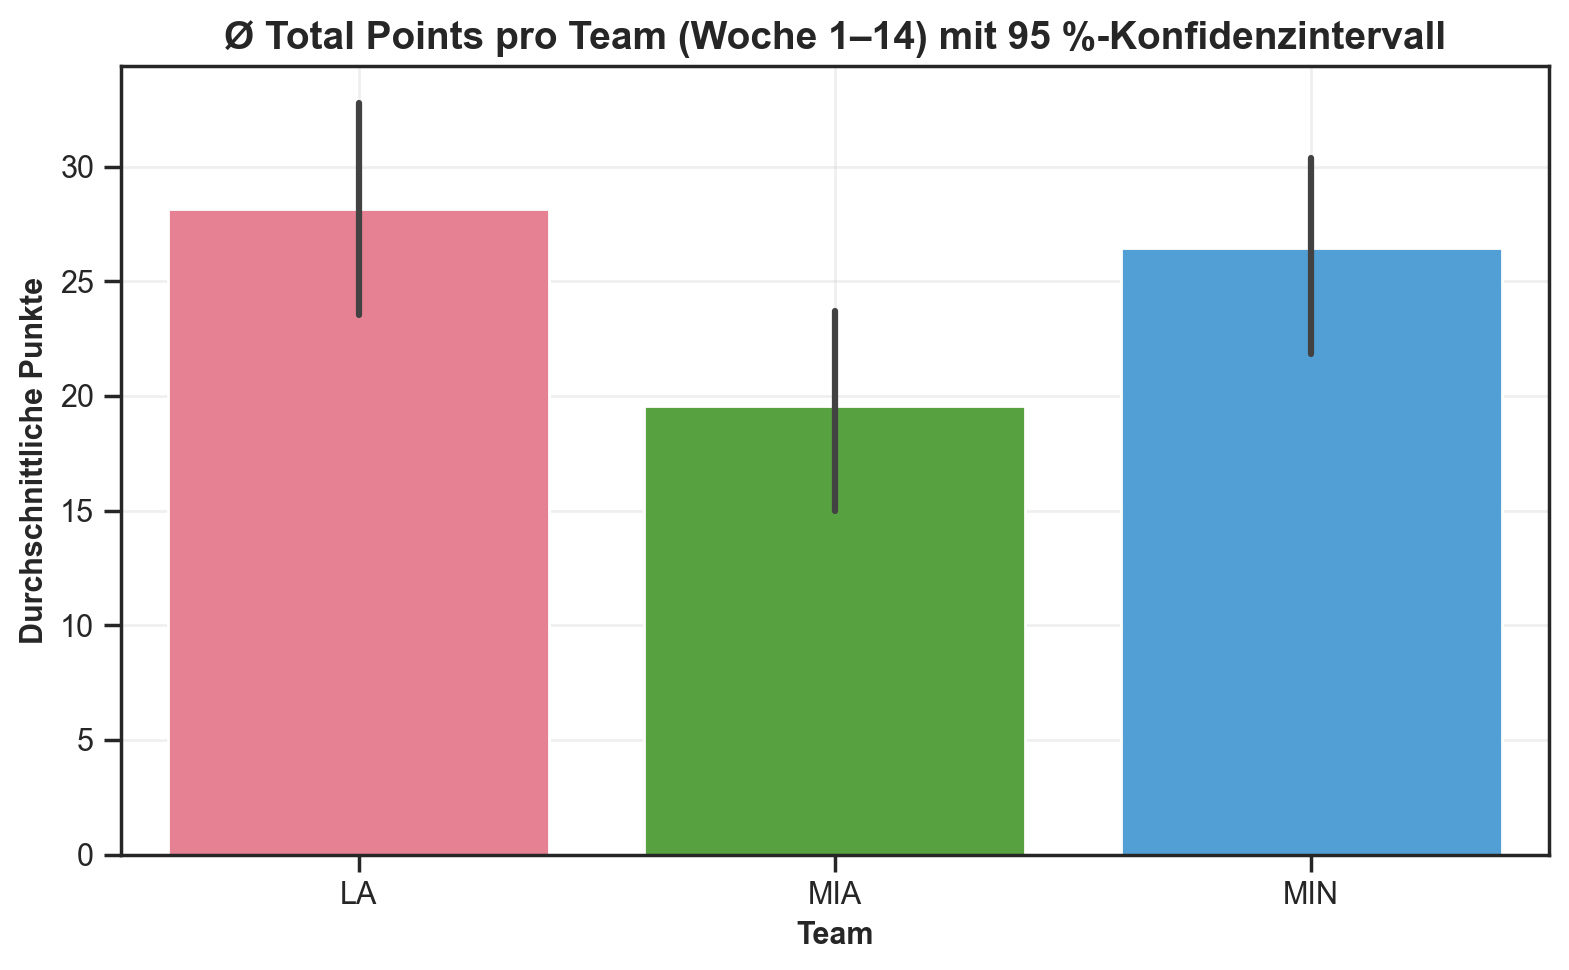

In [12]:
# Seaborn-Stil aktivieren
sns.set_theme(style="ticks", palette="pastel")

# Teams auswählen und filtern
selected_teams = ["MIA", "MIN", "LA"]
filtered_df = df_till_w14[df_till_w14["team"].isin(selected_teams)]

# Balkendiagramm: Durchschnittliche Gesamtpunktzahl pro Team
plt.figure(figsize=(8, 5))
sns.barplot(
    data=filtered_df,
    x="team",
    y="total_points",
    estimator=np.mean,  # Mittelwert berechnen
    ci=95,
    palette="husl",
)

# Beschriftungen und Formatierung
plt.title(
    "Ø Total Points pro Team (Woche 1–14) mit 95 %-Konfidenzintervall",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Team", fontsize=11, fontweight="bold")
plt.ylabel("Durchschnittliche Punkte", fontsize=11, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Die durchschnittlichen Gesamtpunkte pro Team über die Wochen 1–14 zeigen, dass LA und MIN im Schnitt mehr Punkte erzielen als MIA. Die dargestellten Vertrauensintervalle (95 %-Konfidenzintervall) verdeutlichen zusätzlich die Streuung der Punktzahlen pro Team.

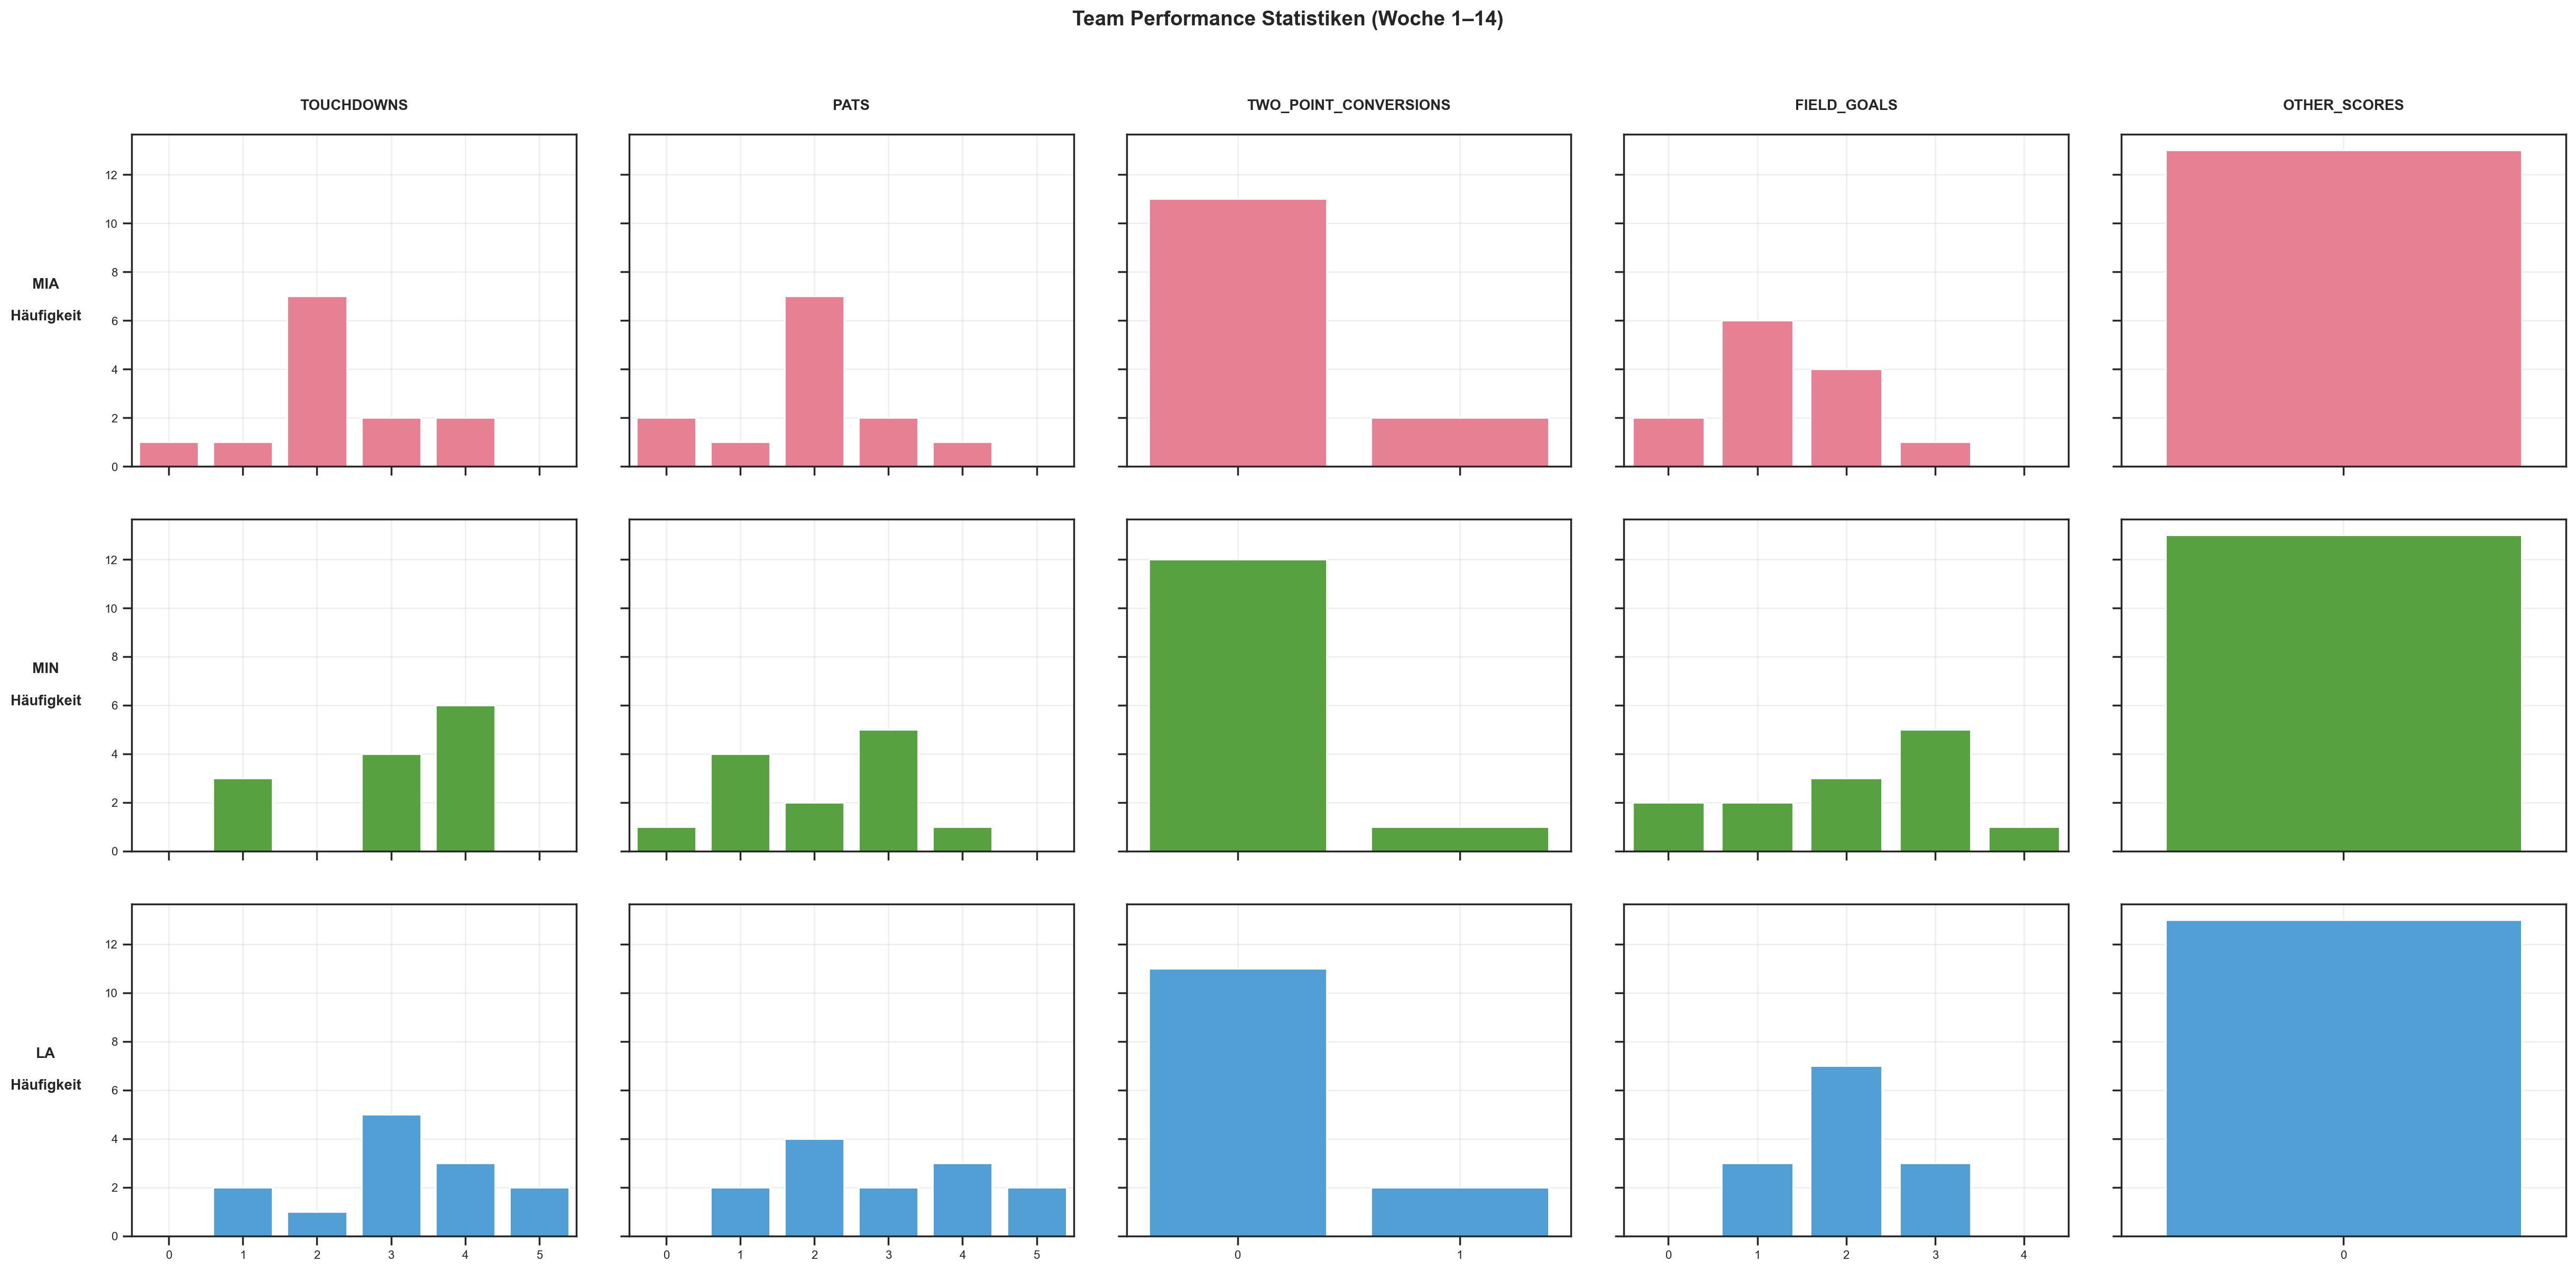

In [13]:
# Höhere Auflösung für Plots im Notebook
%config InlineBackend.figure_format = 'retina'

# Seaborn-Stil aktivieren
sns.set_theme(style="ticks", palette="pastel")

# Teams und betrachtete Metriken festlegen
selected_teams = ['MIA', 'MIN', 'LA']
features = ['touchdowns', 'pats', 'two_point_conversions', 'field_goals', 'other_scores']

# Subplot-Raster erzeugen
fig, axes = plt.subplots(len(selected_teams), len(features), figsize=(25, 12), sharex='col', sharey='row')

# Farbpalette für Team-Farben
palette = sns.color_palette("husl", n_colors=len(selected_teams))

# Schleifen über Teams (Zeilen) und Features (Spalten)
for row_idx, team in enumerate(selected_teams):
    team_data = df_till_w14[df_till_w14['team'] == team]
    
    for col_idx, feature in enumerate(features):
        ax = axes[row_idx, col_idx]

        # Häufigkeit der Werte pro Feature bestimmen
        value_counts = team_data[feature].value_counts().sort_index()

        # Balkendiagramm zeichnen
        sns.barplot(
            x=value_counts.index,
            y=value_counts.values,
            color=palette[row_idx],
            ax=ax
        )

        # Spaltentitel für erste Zeile
        if row_idx == 0:
            ax.set_title(f"\n{feature.upper()}\n", fontsize=10, fontweight='bold')

        # Zeilenbeschriftung mit Teamnamen
        if col_idx == 0:
            ax.set_ylabel(f"{team}\n\nHäufigkeit", fontsize=10, fontweight='bold', rotation=0, labelpad=40, va='center')
        else:
            ax.set_ylabel("")

        ax.set_xlabel('')
        ax.tick_params(axis='both', labelsize=8)
        ax.grid(True, alpha=0.3)

# Gesamttitel und Layout
plt.tight_layout(pad=2.5)
plt.suptitle("Team Performance Statistiken (Woche 1–14)", y=1.02, fontsize=14, fontweight='bold')
plt.show()

Die Grafik zeigt die Häufigkeitsverteilungen verschiedener Scoring-Komponenten (Touchdowns, PATs, Two-Point Conversions, Field Goals und sonstige Punkte) der Teams MIA, MIN und LA in den Wochen 1–14. MIN und LA erreichen häufiger höhere Touchdown-Werte, während MIA bei den Two-Point Conversions am auffälligsten ist. Sonstige Punktarten treten bei allen Teams gar nicht auf. Es gibt jedoch auch andere Teams, bei denen andere Punktarten vorkommen.

### Alle Teams zusammengefasst

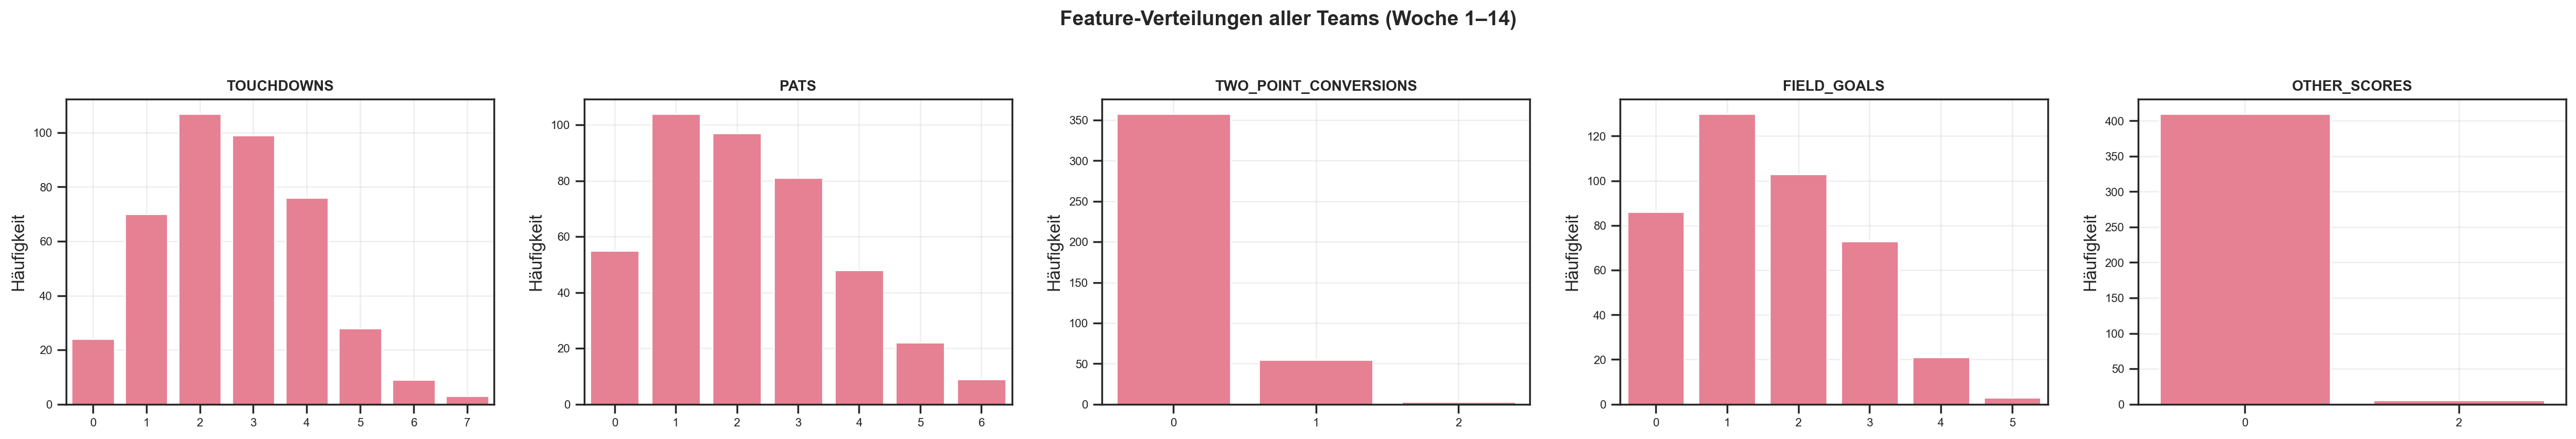

In [14]:
# Seaborn-Stil aktivieren
sns.set_theme(style="ticks", palette="pastel")

# Subplot-Grundlayout: 1 Zeile, je ein Plot pro Feature
fig, axes = plt.subplots(1, len(features), figsize=(25, 4), sharey=False)

# Einheitliche Farbe für alle Balken
color = sns.color_palette("husl", n_colors=1)[0]

# Schleife über alle Features zur Darstellung der Verteilung
for idx, feature in enumerate(features):
    ax = axes[idx]

    # Wertehäufigkeiten berechnen
    value_counts = df_till_w14[feature].value_counts().sort_index()

    # Balkendiagramm zeichnen
    sns.barplot(x=value_counts.index, y=value_counts.values, color=color, ax=ax)

    # Plotbeschriftungen
    ax.set_title(feature.upper(), fontsize=10, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Häufigkeit")
    ax.tick_params(axis="both", labelsize=8)
    ax.grid(True, alpha=0.3)

# Gesamttitel und Layout
plt.tight_layout(pad=2.0)
plt.suptitle(
    "Feature-Verteilungen aller Teams (Woche 1–14)",
    y=1.08,
    fontsize=14,
    fontweight="bold",
)
plt.show()

Die Feature-Verteilungen aller Teams über die Wochen 1–14 zeigen, dass Touchdowns, PATs und Field Goals regelmässig vorkommen und sich typischerweise im mittleren Bereich konzentrieren. Two-Point Conversions und sonstige Punktarten („Other Scores“) treten dagegen nur selten auf.

## Multivariate Analyse

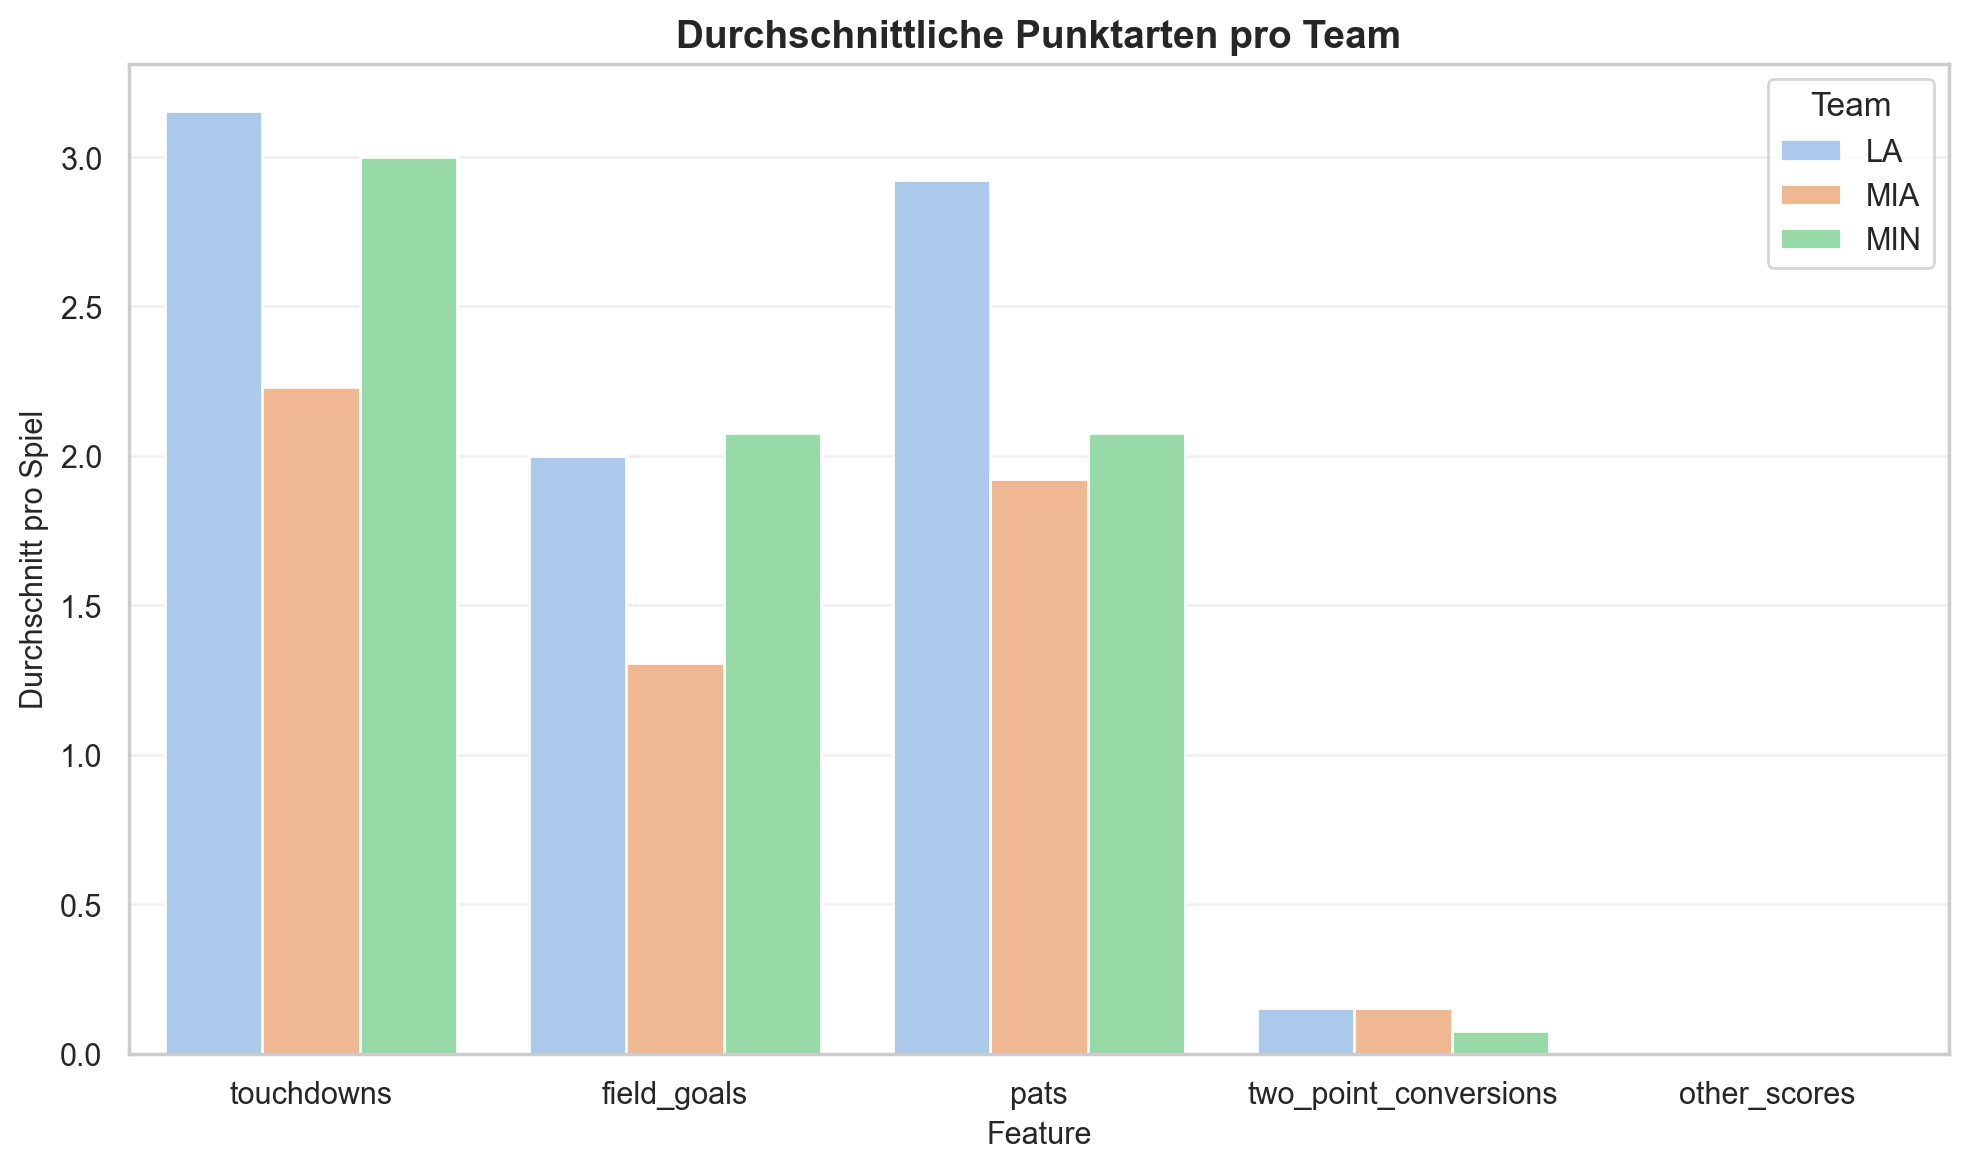

In [15]:
# Seaborn-Stil aktivieren
sns.set_theme(style="whitegrid", palette="pastel")

# Teams und betrachtete Punktarten festlegen
selected_teams = ["MIA", "MIN", "LA"]
features = [
    "touchdowns",
    "field_goals",
    "pats",
    "two_point_conversions",
    "other_scores",
]

# Durchschnittswerte pro Team und Punktart berechnen
grouped = (
    df_till_w14[df_till_w14["team"].isin(selected_teams)]
    .groupby("team")[features]
    .mean()
    .reset_index()
)

# Daten für Seaborn umstrukturieren (Wide → Long Format)
melted = grouped.melt(id_vars="team", var_name="Feature", value_name="Durchschnitt")

# Gruppierter Balkenplot: Vergleich der Mittelwerte pro Feature & Team
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="Feature", y="Durchschnitt", hue="team")

# Plotbeschriftung
plt.title("Durchschnittliche Punktarten pro Team", fontsize=14, fontweight="bold")
plt.xlabel("Feature", fontsize=11)
plt.ylabel("Durchschnitt pro Spiel", fontsize=11)
plt.grid(True, axis="y", alpha=0.3)
plt.legend(title="Team")
plt.tight_layout()
plt.show()

Der Plot zeigt den durchschnittlichen Beitrag verschiedener Punktarten pro Spiel und Team. LA erzielt im Schnitt die meisten Touchdowns und PATs, während MIN leicht bei Field Goals führt. Two-Point Conversions und sonstige Punktarten spielen bei allen Teams eine untergeordnete Rolle.

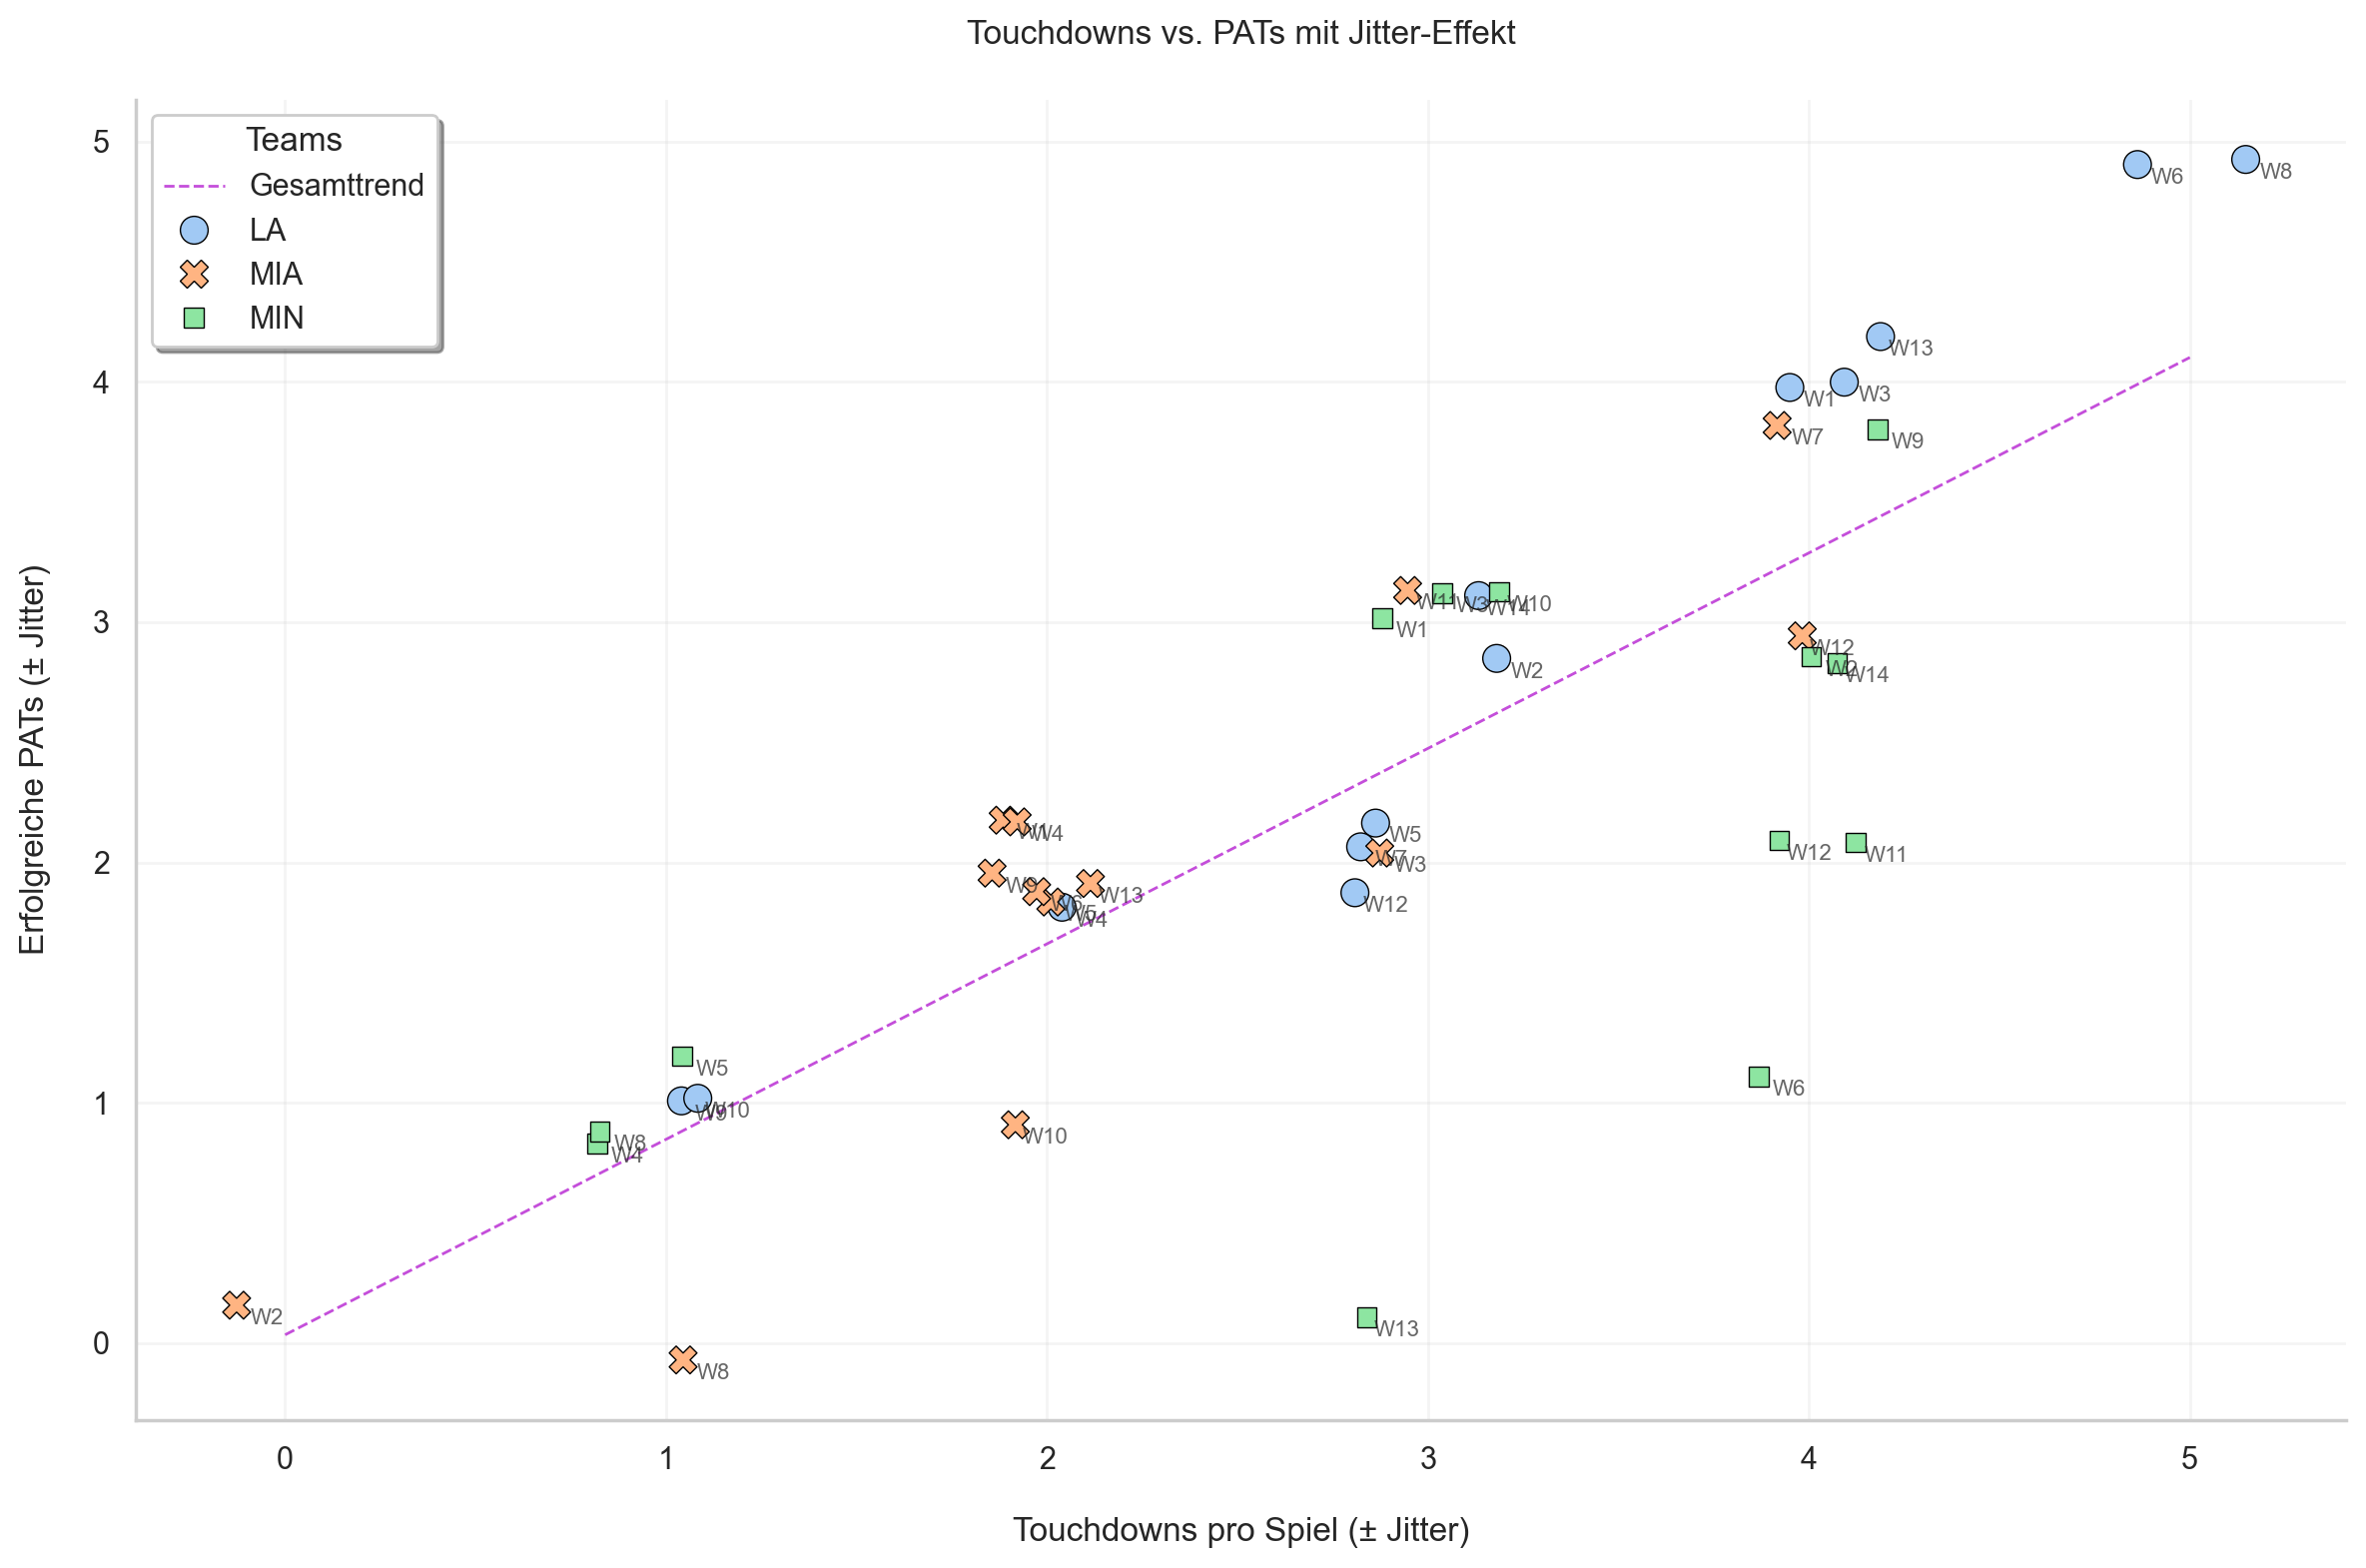

In [16]:
# Daten für Scatterplot vorbereiten (nur ausgewählte Teams)
team_df = df_till_w14[df_till_w14["team"].isin(selected_teams)].copy()

# Stärke des Jitters zur Punktstreuung festlegen
JITTER_STRENGTH = 0.2

# Zufällige Jitter-Werte generieren (für bessere Sichtbarkeit von Überlappungen)
np.random.seed(42)  # Reproduzierbarkeit
team_df["td_jitter"] = team_df["touchdowns"] + np.random.uniform(
    -JITTER_STRENGTH, JITTER_STRENGTH, size=len(team_df)
)
team_df["pats_jitter"] = team_df["pats"] + np.random.uniform(
    -JITTER_STRENGTH, JITTER_STRENGTH, size=len(team_df)
)

plt.figure(figsize=(12, 8))

# Regressionslinie basierend auf Originaldaten (ohne Jitter)
sns.regplot(
    x="touchdowns",
    y="pats",
    data=team_df,
    scatter=False,
    ci=None,
    line_kws={"color": "#C44EDA", "ls": "--", "lw": 1},
    label="Gesamttrend",
)

# Scatterplot mit Jitter-Daten zur besseren Unterscheidbarkeit
scatter = sns.scatterplot(
    x="td_jitter",
    y="pats_jitter",
    hue="team",
    data=team_df,
    style="team",
    s=100,
    edgecolor="black",
    linewidth=0.5,
)

# X- und Y-Achse mit festen Gitterintervallen
plt.xticks(np.arange(0, team_df["touchdowns"].max() + 1))
plt.yticks(np.arange(0, team_df["pats"].max() + 1))

# Wochenlabels zu jedem Punkt anzeigen
for _, row in team_df.iterrows():
    plt.text(
        row["td_jitter"] + 0.08,
        row["pats_jitter"] - 0.08,
        f"W{row['week']}",
        fontsize=8,
        alpha=0.7,
        ha="center",
    )

# Titel und Achsenbeschriftungen
plt.title("Touchdowns vs. PATs mit Jitter-Effekt", pad=20)
plt.xlabel("Touchdowns pro Spiel (± Jitter)", labelpad=15)
plt.ylabel("Erfolgreiche PATs (± Jitter)", labelpad=15)
plt.legend(title="Teams", frameon=True, shadow=True)

# Gitter und Rahmen
plt.grid(alpha=0.2)
sns.despine()
plt.tight_layout()
plt.show()

Der Scatterplot zeigt den Zusammenhang zwischen Touchdowns und erfolgreichen PATs pro Spiel. Der positive Trend verdeutlicht, dass mit steigender Anzahl an Touchdowns auch die Anzahl der erfolgreichen PATs zunimmt, unabhängig vom Team. Der Grund dafür ist, dass PATs nur nach einem Touchdown erzielt werden können. Die Ausreisser deuten auf Spiele hin, in denen Teams viele Touchdowns erzielt haben, aber nicht alle PATs erfolgreich waren.

---

# Modellierung der Wahrscheinlichkeitsverteilungen

Um eine realistische **Monte-Carlo-Simulation** durchzuführen, müssen wir zuerst die zugrunde liegenden Wahrscheinlichkeitsverteilungen für die erzielten Punkte pro Team und Spiel bestimmen. Ziel ist es, mit Hilfe dieser modellierten Verteilungen später beliebig viele Spielresultate simulieren zu können.

Dabei gilt es für jede Punkteart (Touchdowns, Field Goals, Other Scores) herauszufinden, welche Wahrscheinlichkeitsverteilung die real beobachteten Daten am besten beschreibt. Die korrekte Wahl der Verteilung ist entscheidend, um möglichst realistische simulierte Ergebnisse zu erhalten. Für PATs und Two-Point Conversions suchen wir jedoch bewusst keine eigene Wahrscheinlichkeitsverteilung. Diese beiden Punktarten entstehen nicht unabhängig, sondern ausschliesslich im Anschluss an einen Touchdown. Aus diesem Grund modellieren wir sie später konditional abhängig von der Anzahl Touchdowns und verzichten damit auf die Schätzung separater Verteilungen.

## Ursprüngliche Verwendung der `Fitter`-Library

Ursprünglich planten wir, zur automatischen Ermittlung der passenden Verteilungen die Python-Bibliothek **Fitter** zu nutzen. Leider stellte sich heraus, dass die beiden für Zähldaten besonders relevanten Verteilungen – die **Poisson-Verteilung** und die **Negative Binomialverteilung** – von **Fitter** nicht automatisch angepasst (gefittet) werden können. Dies liegt daran, dass die zugrundeliegende SciPy-Bibliothek keine automatische Anpassungsmethode (`.fit()`) für diese diskreten Verteilungen bereitstellt.

Aus diesem Grund bestimmen wir für alle Variablen die Parameter der Verteilungen **manuell** und vergleichen sie anschliessend anhand eines statistischen Kriteriums.

## Verteilungswahl für häufig auftretende Zähldaten: Touchdowns und Field Goals[1]

Die Variablen `touchdowns` und `field_goals` sind **diskrete Zähldaten**, da sie ganze Zahlenwerte annehmen (z. B. 0, 1, 2, ...). Für solche Zählvariablen bieten sich typischerweise zwei klassische Verteilungen besonders an:

- **Poisson-Verteilung**  
  Die Poisson-Verteilung ist die klassische Verteilung für Zähldaten und gibt an, wie wahrscheinlich es ist, dass ein Ereignis in einem festen Intervall (z. B. einem Spiel) 𝑘-mal auftritt. Eine zentrale Annahme dabei ist, dass der Erwartungswert 𝜆 gleich der Varianz σ² ist.

  Formel der Poisson-Verteilung:
   $$
    P(X = k) \;=\; \frac{\lambda^k \, e^{-\lambda}}{k!},
    \quad k = 0,1,2,\dots
  $$
    
  -  $X$: Zufallsvariable (Anzahl der Ereignisse, z. B. Touchdowns in einem Spiel)  
  -  $k\in\{0,1,2,\dots\}$: konkrete Ausprägung  
  -  $\lambda$: Erwartungswert der Verteilung (im Code: `lam`)

- **Negative Binomialverteilung (NB)**  
  Die Negative Binomialverteilung erweitert die Poisson-Verteilung um die Möglichkeit der Überdispersion – das heisst, sie erlaubt eine Varianz σ², die grösser ist als der Erwartungswert. Wenn die empirische Varianz deutlich über 𝜆 liegt, passt die NB-Verteilung oft besser als die Poisson-Verteilung.

  Formel der Negativen Binomialverteilung:
  $$
  P(X = k)
  = \binom{k + r - 1}{k}\;p^{r}\;(1 - p)^{k},
  \quad k = 0,1,2,\dots
  $$

  - $X$: Zufallsvariable (Anzahl der Ereignisse)  
  - $k\in\{0,1,2,\dots\}$: konkrete Ausprägung  
  - $r$: “Grösse” oder Anzahl der Erfolge bis zum Abbruch (im Code: `r`)  
  - $p$: Erfolgswahrscheinlichkeit (im Code: `p`) 

Um eine fundierte Entscheidung zu treffen, welche dieser beiden Verteilungen besser geeignet ist, vergleichen wir sie anhand des **Sum of Squared Errors (SSE)**. Das Modell mit dem kleineren SSE beschreibt die beobachteten Daten besser.

## Erklärung des Sum of Squared Errors (SSE) [2]

Der **Sum of Squared Errors (SSE)** ist eine einfache Kennzahl zur Modellselektion, bei der die quadrierten Abweichungen zwischen beobachteten und erwarteten Häufigkeiten aufsummiert werden. Ein kleinerer SSE-Wert bedeutet, dass das Modell die beobachteten Daten besser approximiert.

Die Formel für den SSE lautet:

$$
\mathrm{SSE} = \sum_{k} \bigl(O_k - E_k\bigr)^2
$$

Dabei gilt:  
$O_k$: Beobachtete Häufigkeit der Ausprägung $k$ (z. B. Anzahl Spiele mit $k$ Touchdowns)  
$E_k$: Erwartete Häufigkeit unter dem Modell für die Ausprägung $k$

Im folgenden Abschnitt führen wir diesen Vergleich für `touchdowns` und `field_goals` durch, indem wir für jedes Modell die beobachteten Häufigkeiten den erwarteten Häufigkeiten gegenüberstellen und den SSE berechnen.

In [17]:
# Zählvariablen, die modelliert werden sollen
count_features = ["touchdowns", "field_goals"]

# Dictionary zur Speicherung der Ergebnisse
results = {}

# Modellvergleich für jede Variable anhand von SSE
for feat in count_features:
    # Daten als NumPy-Array extrahieren
    data = df_till_w14[feat].values
    n = len(data)

    # Erwartungswert (λ) und Stichprobenvarianz (σ²) berechnen
    lam = data.mean()
    var = data.var(ddof=1)

    # Beobachtete Häufigkeiten
    max_k = data.max()
    ks = np.arange(max_k + 1)
    obs_counts = np.bincount(data, minlength=max_k + 1)

    # Modell 1: Poisson-Verteilung
    exp_counts_pois = stats.poisson.pmf(ks, lam) * n
    sse_pois = ((obs_counts - exp_counts_pois) ** 2).sum()

    # Modell 2: Negative Binomial (nur bei Überdispersion)
    if var > lam:
        r = lam**2 / (var - lam)
        p = r / (r + lam)
        exp_counts_nbinom = stats.nbinom.pmf(ks, r, p) * n
        sse_nbinom = ((obs_counts - exp_counts_nbinom) ** 2).sum()
    else:
        sse_nbinom = np.inf  # Nicht sinnvoll bei Varianz ≤ λ

    # Besseres Modell basierend auf SSE (kleiner ist besser)
    better = "poisson" if sse_pois < sse_nbinom else "nbinom"

    # Ergebnisse speichern
    results[feat] = {
        "lam": lam,
        "var": var,
        "sse_poisson": sse_pois,
        "sse_nbinom": sse_nbinom,
        "better": better,
        **({"r": r, "p": p} if var > lam else {}),
    }

    # Konsolenausgabe
    print(f"\n=== {feat} ===")
    print(f" Parameter λ = {lam:.3f}, Varianz σ² = {var:.3f}")
    print(f" SSE Poisson    = {sse_pois:.1f}")
    if var > lam:
        print(f" SSE  NB        = {sse_nbinom:.1f}  (r={r:.2f}, p={p:.3f})")
    else:
        print(" NB nicht möglich (Varianz ≤ λ)")
    print(" ➜ Besser passt:", better)


=== touchdowns ===
 Parameter λ = 2.644, Varianz σ² = 2.090
 SSE Poisson    = 468.1
 NB nicht möglich (Varianz ≤ λ)
 ➜ Besser passt: poisson

=== field_goals ===
 Parameter λ = 1.572, Varianz σ² = 1.402
 SSE Poisson    = 355.1
 NB nicht möglich (Varianz ≤ λ)
 ➜ Besser passt: poisson


## Interpretation der Resultate: Touchdowns und Field Goals

Die Ergebnisse für die Variablen `touchdowns` und `field_goals` zeigen jeweils, welche Verteilung besser zu den beobachteten Daten passt. Dabei werden der Parameter λ, die Varianz σ² und der SSE-Wert beider getesteten Verteilungen angegeben.

### Ergebnisse

- **Touchdowns**  
  - Parameter λ = 2.644, Varianz σ² = 2.090  
  - Die Varianz σ² ist kleiner als λ, daher ist die Negative Binomialverteilung nicht sinnvoll (keine Überdispersion).  
  - Die **Poisson-Verteilung** mit Parameter λ passt damit am besten.

- **Field Goals**  
  - Parameter λ = 1.572, Varianz σ² = 1.402  
  - Auch hier ist σ² < λ, somit scheidet das NB-Modell aus.  
  - Die **Poisson-Verteilung** mit Parameter λ beschreibt die Field Goals am besten.

---

## Verteilungswahl stark null-lastiger Variable: Other Scores [3]

Für die Variable `other_scores` liegt ein Spezialfall vor:  
Dieses Ereignis tritt in NFL-Spielen selten auf, weshalb diese Variable stark null-lastig ist (d.h. viele Spiele haben einen Wert von 0).

In solchen Fällen kann eine einfache Poisson- oder Negative Binomialverteilung oft nicht ausreichen, da diese Verteilung nicht gut mit einer hohen Anzahl an Null-Werten umgehen können. Daher müssen wir zusätzlich **Zero-Inflated-Modelle** (Null-inflationierte Modelle) in Betracht ziehen, welche speziell entwickelt wurden, um eine hohe Anzahl an Nullen in den Daten zu berücksichtigen.

### Vergleich der möglichen Modelle

Um die passende Verteilung für diese stark null-lastigen Variable zu ermitteln, vergleichen wir folgende Modelle miteinander:

- **Poisson-Verteilung**  
  Standardmodell für Zählvariablen ohne besondere Berücksichtigung von Null-Inflation. Formel wie oben.

- **Negative Binomialverteilung (NB)**  
  Erweiterung der Poisson-Verteilung, erlaubt Überdispersion (σ² < λ), ebenfalls ohne spezielle Null-Inflation. Formel wie oben.

- **Zero-Inflated Poisson (ZIP)**  
  Poisson-Modell, erweitert um eine zusätzliche Komponente, welche speziell die Wahrscheinlichkeit von Null-Werten modelliert.

  Formel der zero-inflated Poisson-Verteilung:
  $$
  P(X = 0) \;=\; \pi + (1-\pi)\,e^{-\lambda},  
  \quad
  P(X = k) \;=\; (1-\pi)\,\frac{\lambda^k\,e^{-\lambda}}{k!},\; k>0
  $$
    - $\pi$: Inflationswahrscheinlichkeit für zusätzliche Nullen (im Code: `pi`)
    - $\lambda$: Poisson-Parameter für den Nicht-Null-Anteil (im Code: `lam`)

- **Zero-Inflated Negative Binomial (ZINB)**  
  Negative Binomialverteilung, erweitert um eine zusätzliche Null-Inflationskomponente.

  Formel der zero-inflated negative binomial-Verteilung:
  $$
  P(X = 0) \;=\; \pi + (1-\pi)\,\binom{r + 0 - 1}{0}\,p^{r}\,(1-p)^{0},  
  \quad
  P(X = k) \;=\; (1-\pi)\,\binom{k + r - 1}{k}\,p^{r}\,(1-p)^{k},\; k>0
  $$
    - $\pi$: Inflationswahrscheinlichkeit (im Code: `pi`)  
    - $r,p$: Parameter der NB-Komponente (im Code: `r`, `p`)

Die Entscheidung, welches dieser Modelle die Daten am besten beschreibt, treffen wir wiederum mit Hilfe des **Sum of Squared Errors (SSE)**. Das Modell mit dem kleinsten SSE-Wert gilt als das am besten geeignete.

Im Folgenden führen wir diesen Modellvergleich für `other_scores` durch.

In [18]:
# Warnungen unterdrücken (z. B. Konvergenzhinweise)
warnings.filterwarnings("ignore")

# Features mit starkem Zero-Inflation-Anteil
zi_features = ["other_scores"]

# Ergebnisse speichern
zi_results = {}

# Modellvergleich für jedes Feature mit hoher Nullhäufigkeit anhand SSE
for feat in zi_features:
    y = df_till_w14[feat].values
    n = len(y)

    # 1) Beobachtete Häufigkeiten von 0 bis max(y)
    max_k = y.max()
    ks = np.arange(max_k + 1)
    obs_counts = np.bincount(y, minlength=max_k + 1)

    # 2) Modelle fitten (Intercept-only)
    X = np.ones((n, 1))
    pois = sm.GLM(y, X, family=sm.families.Poisson()).fit(disp=False)
    nb = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit(disp=False)
    zip_mod = ZeroInflatedPoisson(y, X, X, inflation="logit").fit(disp=False)
    zinb_mod = ZeroInflatedNegativeBinomialP(y, X, X, inflation="logit").fit(disp=False)

    # 3) Parameter extrahieren
    # --- Poisson ---
    lam_pois = np.exp(pois.params[0])

    # --- NegBinomial (GLM NB2: Var=y+α y², scale=α) ---
    lam_nb = np.exp(nb.params[0])
    alpha_nb = nb.scale
    r_nb = 1 / alpha_nb
    p_nb = r_nb / (r_nb + lam_nb)

    # --- Zero-Infl Poisson ---
    # params: [infl_const, main_const]
    infl_c_zip, main_c_zip = zip_mod.params
    pi_zip = 1 / (1 + np.exp(-infl_c_zip))
    lam_zip = np.exp(main_c_zip)

    # --- Zero-Infl NB ---
    # params: [infl_const, main_const, log(alpha)]
    infl_c_zinb, main_c_zinb, log_alpha_zinb = zinb_mod.params
    pi_zinb = 1 / (1 + np.exp(-infl_c_zinb))
    lam_zinb = np.exp(main_c_zinb)
    alpha_zinb = np.exp(log_alpha_zinb)
    r_zinb = 1 / alpha_zinb
    p_zinb = r_zinb / (r_zinb + lam_zinb)

    # 4) Erwartete Häufigkeiten pro k berechnen
    exp_pois = poisson.pmf(ks, lam_pois) * n
    exp_nb = nbinom.pmf(ks, r_nb, p_nb) * n

    # ZIP: P(Y=0) = π + (1-π)e^{-λ}, P(Y=k>0) = (1-π) Poisson(k;λ)
    exp_zip = (
        np.where(
            ks == 0,
            pi_zip + (1 - pi_zip) * poisson.pmf(0, lam_zip),
            (1 - pi_zip) * poisson.pmf(ks, lam_zip),
        )
        * n
    )

    # ZINB: analog, mit NB-Pmf
    exp_zinb = (
        np.where(
            ks == 0,
            pi_zinb + (1 - pi_zinb) * nbinom.pmf(0, r_zinb, p_zinb),
            (1 - pi_zinb) * nbinom.pmf(ks, r_zinb, p_zinb),
        )
        * n
    )

    # 5) SSE für jedes Modell
    sse_pois = ((obs_counts - exp_pois) ** 2).sum()
    sse_nb = ((obs_counts - exp_nb) ** 2).sum()
    sse_zip = ((obs_counts - exp_zip) ** 2).sum()
    sse_zinb = ((obs_counts - exp_zinb) ** 2).sum()

    sses = {
        "Poisson": sse_pois,
        "NegBinomial": sse_nb,
        "ZIP": sse_zip,
        "ZINB": sse_zinb,
    }
    best = min(sses, key=sses.get)

    # 6) Ausgabe
    print(f"\n=== {feat} ===")
    for name, sse in sses.items():
        print(f"{name:12}: SSE = {sse:.1f}")
    print("➜ Bestes Modell:", best)

    zi_results[feat] = {"sse": sses, "best": best}


=== other_scores ===
Poisson     : SSE = 203.9
NegBinomial : SSE = 192.9
ZIP         : SSE = 22.4
ZINB        : SSE = 72.0
➜ Bestes Modell: ZIP


## Interpretation der Resultate: Auswahl des besten Modelles für stark null-lastige Variable

Die Ergebnisse für die Variable `other_scores` zeigen die SSE-Werte der getesteten Modelle und welches davon am besten geeignet ist.

### Ergebnisse

- **Other Scores**:
  - SSE Poisson: 203.9
  - SSE Negative Binomial: 192.9
  - SSE Zero-Inflated Poisson (ZIP): 22.4
  - SSE Zero-Inflated Negative Binomial (ZINB): 72.0
  - ➜ Bestes Modell: **Zero-Inflated Poisson (ZIP)**

Das Zero-Inflated-Modell (ZIP) ist hier mit einer SSE von 22.4 deutlich überlegen. Das weist darauf hin, dass es in den Daten eine erhebliche Anzahl zusätzlicher Nullen gibt, die durch einfache Poisson- oder Negative-Binomial-Modelle nicht abgedeckt werden. Das ZIP-Modell erfasst die "Null-Inflation" und liefert somit die beste Anpassung an die beobachtete Häufigkeitsverteilung.

---

## Visualisierung der Verteilungen

Im folgenden Abschnitt vergleichen wir für jede der drei Zählvariablen (`touchdowns`, `field_goals`, `other_scores`) die empirisch beobachtete Verteilung mit der jeweils am besten passenden theoretischen Verteilung.
Dazu stellen wir die relative Häufigkeit der beobachteten Werte (Bars) der Wahrscheinlichkeitsmassefunktion (PMF) gegenüber:  
- Für `touchdowns` und `field_goals` wird die Poisson-Verteilung verwendet.
- Für `other_scores` kommt aufgrund der hohen Nullhäufigkeit das Zero-Inflated Poisson-Modell (ZIP) zum Einsatz.

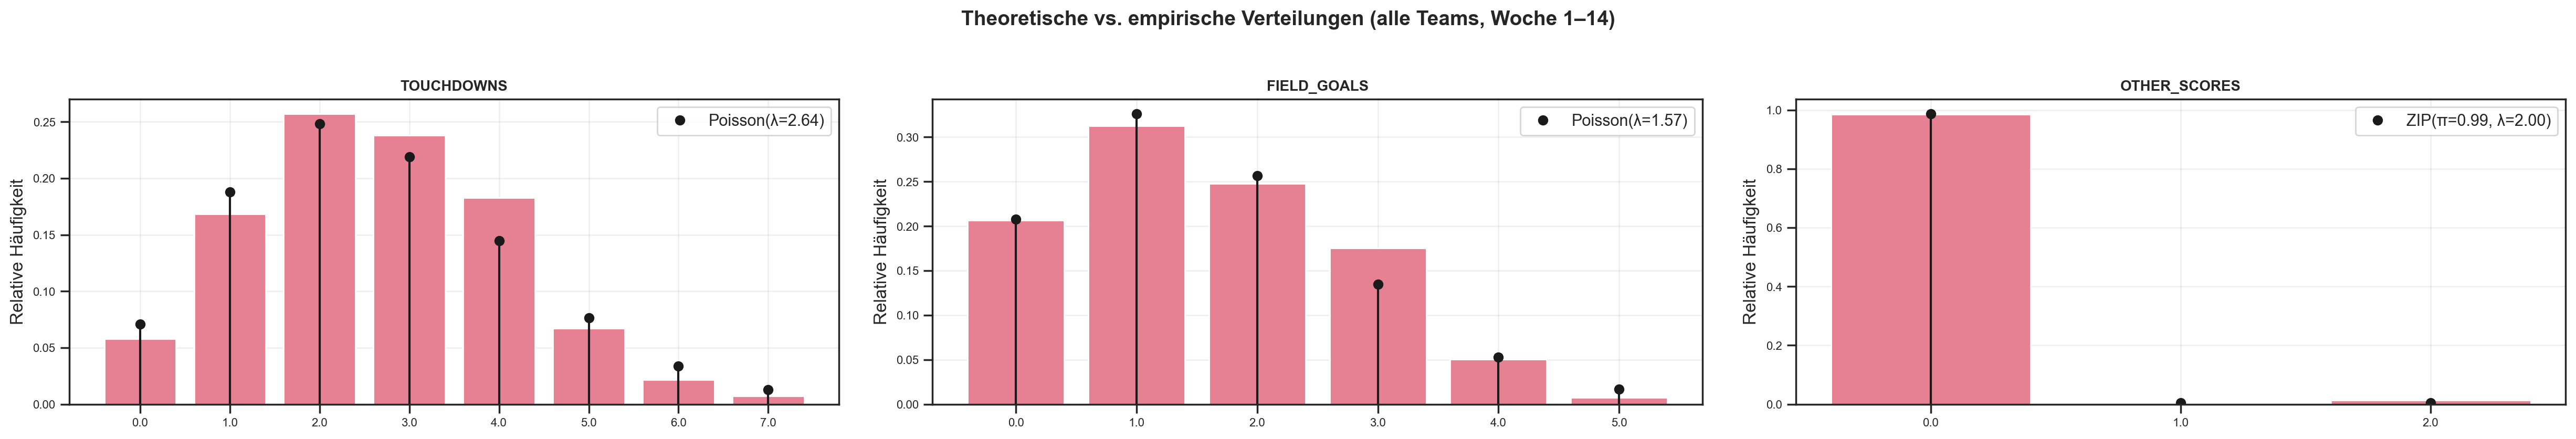

In [19]:
# Seaborn-Stil aktivieren
sns.set_theme(style="ticks", palette="pastel")

# Zählvariablen, die analysiert werden sollen
features = [
    "touchdowns",
    "field_goals",
    "other_scores",
]

# Zero-Inflated-Poisson-Parameter für "other_scores" berechnen
y_other = df_till_w14["other_scores"].values
pi_zip = np.mean(y_other == 0)  # Null-Inflationsanteil (π)
lam_zip = (
    np.mean(y_other[y_other > 0]) if np.any(y_other > 0) else 0
)  # λ für Nicht-Null-Werte

# Subplots: je ein Plot pro Feature
fig, axes = plt.subplots(1, len(features), figsize=(25, 4), sharey=False)

# Farbe für Histogramme
color = sns.color_palette("husl", n_colors=1)[0]

for idx, feat in enumerate(features):
    ax = axes[idx]
    data = df_till_w14[feat].values

    # Histogramm
    bins = np.arange(data.max() + 2) - 0.5
    counts, edges = np.histogram(data, bins=bins, density=True)
    centers = (edges[:-1] + edges[1:]) / 2

    # Empirische Verteilung
    sns.barplot(x=centers, y=counts, color=color, ax=ax)

    # Diskrete x-Werte für die PMF
    x = np.arange(0, int(data.max()) + 1)

    # Theoretische Verteilung per stem-Plot
    if feat != "other_scores":
        lam = data.mean()
        pmf = poisson.pmf(x, lam)
        markerline, stemlines, baseline = ax.stem(
            x, pmf, linefmt="k-", markerfmt="ko", basefmt=" "
        )
        markerline.set_markersize(6)
        ax.legend([markerline], [f"Poisson(λ={lam:.2f})"])
    else:
        pmf = np.where(
            x == 0,
            pi_zip + (1 - pi_zip) * poisson.pmf(0, lam_zip),
            (1 - pi_zip) * poisson.pmf(x, lam_zip),
        )
        markerline, stemlines, baseline = ax.stem(
            x, pmf, linefmt="k-", markerfmt="ko", basefmt=" "
        )
        markerline.set_markersize(6)
        ax.legend([markerline], [f"ZIP(π={pi_zip:.2f}, λ={lam_zip:.2f})"])

    # Achsen & Titel
    ax.set_title(feat.upper(), fontsize=10, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Relative Häufigkeit")
    ax.tick_params(axis="both", labelsize=8)
    ax.grid(True, alpha=0.3)

# Layout & Titel
plt.tight_layout(pad=2.0)
plt.suptitle(
    "Theoretische vs. empirische Verteilungen (alle Teams, Woche 1–14)",
    y=1.08,
    fontsize=14,
    fontweight="bold",
)
plt.show()

Diese Gegenüberstellung macht sichtbar, dass die empirischen Spielverteilungen gut durch die theoretischen Modelle approximiert werden. Insbesondere die **ZIP-Verteilung** erfasst die dominanten Nullhäufigkeiten bei `other_scores` deutlich besser als klassische Zählverteilungen.

### Fazit zur Verteilungswahl

Insgesamt bestätigt die Visualisierung die zuvor statistisch ermittelte Wahl der Modelle:

- Die **Poisson-Verteilung** eignet sich hervorragend für die häufigeren Zählvariablen wie Touchdowns und Field Goals, bei denen keine oder nur geringe Überdispersion vorliegt.
- Die seltenere und stark null-lastige Variable `other_scores` wird durch das **Zero-Inflated Poisson-Modell (ZIP)** am besten beschrieben.

Diese modellbasierten Verteilungen bilden die Grundlage für die nachfolgenden Monte-Carlo-Simulationen, in denen pro Team realistisches Scoringverhalten simuliert wird.

Die Variablen `pat` und `two_point_conversion` werden aufgrund ihrer **strukturellen Abhängigkeit von Touchdowns** nicht separat modelliert, sondern im nächsten Abschnitt konditional abgeleitet.

---

# Modellierung der Scores

Für die drei Teil-Scores (`touchdowns`, `field_goals`, `other_scores`) wird pro Team die jeweilige Verteilung parametrisiert.

Die so geschätzten Parameter pro Team werden im Dictionary `team_dist_params` gespeichert.

## Verwendete Wahrscheinlichkeitsverteilungen

### Poisson-Verteilung

- Einsatz für `touchdowns` und `field_goals`.
- **Parameter**  
  - `λ` (im Code: `lam`): Erwartungswert der Zählvariable.  

### Zero-Inflated Poisson (ZIP)

- Einsatz für `other_scores`.  
- **Parameter**  
  1. `π` (im Code: `pi`): Anteil aller Beobachtungen, die strukturell auf 0 gesetzt sind.  
  2. `λ` (im Code: `lam`): Erwartungswert Poisson‑Komponente (berechnet auf den Werten > 0).

### Gespeicherte Parameter pro Team

| Verteilungstyp | Parameter    | Bedeutung                                          |
|---------------:|-------------:|----------------------------------------------------|
| Poisson        | `lam`        | Erwartungswert aus den Werten von Woche 1–14       |
| ZIP            | `pi`         | Anteil der Nullwerte                               |
| ZIP            | `lam`        | Erwartungswert der nicht-null‑Werte                |

## Abhängigkeiten zwischen Touchdowns und PATs / 2 Point Conversions
PATs (Point After Touchdown) und 2-Point Conversions sind im American Football **nicht unabhängige Punktarten**, sondern **direkt an das Eintreten eines Touchdowns gebunden**. Nach jedem Touchdown hat ein Team die Möglichkeit, **entweder einen PAT** oder eine **2-Point Conversion** zu versuchen – jedoch **nicht beides gleichzeitig**. Somit ist die maximale Anzahl möglicher Extrapunkte (egal welcher Art) stets durch die Anzahl der erzielten Touchdowns begrenzt.

Aus diesem Grund modellieren wir `pat` und `two_point_conversion` nicht als eigene Verteilungen, sondern als binomialverteilte Zufallsvariablen, deren Anzahl an Versuchen direkt von der simulierten Anzahl Touchdowns abhängt. Dies ist statistisch sinnvoll und strukturell realitätsnah.

Für jedes simulierte Spiel gilt:
- Zunächst wird die Anzahl Touchdowns gezogen.
- Danach wird für jeden Touchdown per Zufallsentscheid bestimmt, ob ein PAT oder eine 2-Point Conversion versucht wird.
- Anschliessend wird – je nach Versuchstyp – der Erfolg simuliert.

Diese strukturierte Abhängigkeit verhindert **unrealistische Konstellationen** wie z. B. mehr PATs als Touchdowns und bildet die Realität des Spiels deutlich genauer ab. Sie verbessert die Modellgüte, da die Wahrscheinlichkeitsverteilungen der Extrapunkte **nicht isoliert**, sondern **konditional abhängig von den Touchdowns** modelliert werden.

![Baumdiagramm](./Baumdiagramm-PATs-und-2PCs.png)
#### LaTeX-Berechnungen zu den abhängigen Zufallsvariablen
- $T =$ Anzahl Touchdowns
- $A \sim \text{Binomial}(T,\, p_{\text{2PC\_try}})$: Anzahl 2PC-Versuche
- $S_2 \sim \text{Binomial}(A,\, p_{\text{2PC\_succ}})$: Erfolgreiche 2PCs
- $S_1 \sim \text{Binomial}(T - A,\, p_{\text{PAT\_succ}})$: Erfolgreiche PATs

Der gesamte Score wird dann wie folgt berechnet:
$$
\text{Score} = 6 \cdot T + 2 \cdot S_2 + 1 \cdot S_1 + 3 \cdot \text{FieldGoals} + \text{OtherScores}
$$

Wie Wahrscheinlichkeiten für einen erfolgreichen PAT oder eine 2-Point Conversion werden wir nicht von den gegebenen Daten ableiten, sondern sie aus der Literatur entnehmen. Diese Werte sind in der Regel stabiler und weniger anfällig für Schwankungen als die tatsächlichen Spielstatistiken. Diese unterscheiden sich somit nicht nach Team, sondern sind für alle Teams gleich: 
- Versuchsquote PAT: 0.95 [8]
- Versuchsquote 2-Point Conversion: 0.05 [8]
- Erfolgsquote PAT: 0.95 [4]
- Erfolgsquote 2-Point Conversion: 0.475 [4]

Diese Parameter bilden die Grundlage für die spätere Monte‑Carlo‑Simulation.

In [20]:
# Liste aller Teams
teams = df_till_w14["team"].unique()
team_dist_params = {}

for team in teams:
    # Daten des aktuellen Teams herausfiltern
    team_data = df_till_w14[df_till_w14["team"] == team]
    params = {}

    # Touchdowns und Field Goals modellieren mit Poisson-Verteilungen
    for var in ["touchdowns", "field_goals"]:
        lam = team_data[var].mean()
        params[var] = {"dist": "poisson", "lam": lam}

    # "other_scores" separat behandeln (viele Nullwerte → ZIP-Modell)
    y = team_data["other_scores"].values
    pi = np.mean(y == 0)  # Anteil der Nullwerte

    # λ nur auf Basis der >0-Werte berechnen
    y_pos = y[y > 0]
    lam_pos = y_pos.mean() if len(y_pos) > 0 else 0

    params["other_scores"] = {
        "dist": "zip_manual",  # Hinweis auf manuelles ZIP-Modell
        "pi": pi,  # Zero-Inflation-Anteil
        "lam": lam_pos,  # Erwartungswert der Poisson-Komponente
    }

    # Feste Wahrscheinlichkeiten für das Verhalten nach einem Touchdown
    # Wahrscheinlichkeit, dass eine 2-Point Conversion versucht wird
    params["p_2pc_try"] = 0.05  # 5 % der Touchdowns führen zu einem 2PC-Versuch

    # Wahrscheinlichkeit, dass ein PAT versucht wird (implizit)
    params["p_pat_try"] = 0.95  # 95 % der Touchdowns führen zu einem PAT-Versuch

    # Erfolgswahrscheinlichkeit bei Versuch
    params["p_2pc_succ"] = 0.475  # 47.5 % Erfolgsquote bei 2PC
    params["p_pat_succ"] = 0.95  # 95 % Erfolgsquote bei PAT

    # Parameter im Gesamt-Dictionary speichern
    team_dist_params[team] = params

Mit diesem vorbereiteten Parameter-Set können wir im nächsten Schritt für jedes Team und jeden Score simulierte Werte generieren basierend auf den team-individuellen Wahrscheinlichkeitsverteilungen.

---

# Monte Carlo Simulation

Im Folgenden führen wir die eigentliche **Monte-Carlo-Simulation** durch.

Für alle Spiele aus Woche 15 simulieren wir jeweils 10'000 mögliche Punktzahlen pro Team, basierend auf den zuvor modellierten Teil-Scores. Dabei ziehen wir die Werte bei jedem Durchlauf frisch aus den entsprechenden Verteilungen.

Anschliessend werden die simulierten Punktzahlen zu einem Gesamtscore aufsummiert und mit dem realen Spielergebnis verglichen. Der Sieger der Simulation ergibt sich aus dem höheren mittleren Score über die 10'000 Simulationen hinweg.

In [21]:
# Anzahl der Simulationen pro Spiel
n_sims = 10_000

# Liste zur Speicherung aller Simulationsergebnisse
sim_results = []

# Schleife über alle Spiele aus Woche 15
for _, game in df_w15.iterrows():
    home, away = game.home_team, game.away_team  # Teamnamen extrahieren
    real_home, real_away = game.home_score, game.away_score  # Tatsächliche Punktzahlen

    # Simuliere Gesamtpunktzahl eines Teams auf Basis der Modellparameter
    def draw_total(team):
        params = team_dist_params[team]  # Modellparameter des Teams laden

        # Touchdowns simulieren (Poisson-verteilte Zufallsvariablen)
        td = poisson.rvs(mu=params["touchdowns"]["lam"], size=n_sims)

        # Anzahl der 2PC-Versuche (binomial verteilt)
        two_pc_try = np.random.binomial(td.astype(np.int32), params["p_2pc_try"])

        # Der Rest sind PAT-Versuche
        pat_try = td - two_pc_try

        # Erfolgreiche 2PCs (2 Punkte pro Erfolg)
        tp = np.random.binomial(two_pc_try, params["p_2pc_succ"]) * 2

        # Erfolgreiche PATs (1 Punkt pro Erfolg)
        pat = np.random.binomial(pat_try.astype(np.int32), params["p_pat_succ"]) * 1

        # Punkte aus Touchdowns (6 Punkte je TD)
        td_points = td * 6

        # Field Goals simulieren (Poisson-verteilte Anzahl, 3 Punkte je FG)
        fg = poisson.rvs(mu=params["field_goals"]["lam"], size=n_sims) * 3

        # "Other Scores" simulieren mit Zero-Inflated Poisson
        pi, lam0 = params["other_scores"]["pi"], params["other_scores"]["lam"]
        u = np.random.rand(n_sims)  # Zufallszahlen für Zero-Inflation
        os = np.where(u < pi, 0, poisson.rvs(mu=lam0, size=n_sims))  # ZIP-Logik

        # Gesamtpunktzahl: TD + Zusatzpunkte + Field Goals
        total_points = td_points + tp + pat + fg + os

        return total_points

    # Gesamtpunkte für Heim- und Auswärtsteam simulieren
    total_home = draw_total(home)
    total_away = draw_total(away)

    # Mittelwert der simulierten Punktzahlen
    mean_home, mean_away = total_home.mean(), total_away.mean()

    # Vorhergesagter Sieger basierend auf höherem Mittelwert
    pred = home if mean_home > mean_away else away
    # Tatsächlicher Sieger laut realem Score
    actual = home if real_home > real_away else away

    # Gewinnwahrscheinlichkeiten berechnen
    p_home = round((total_home > total_away).mean(), 4)
    p_away = round(1 - p_home, 4)

    # Ergebnis speichern
    sim_results.append(
        {
            "home_team": home,
            "away_team": away,
            "real_home": real_home,
            "real_away": real_away,
            "mean_sim_home": mean_home,
            "mean_sim_away": mean_away,
            "predicted_winner": pred,
            "actual_winner": actual,
            "p_home_win": p_home,
            "p_away_win": p_away,
        }
    )

# Ergebnisse in DataFrame umwandeln
sim_df = pd.DataFrame(sim_results)

# Vorhersagegenauigkeit berechnen (Anteil korrekt vorhergesagter Sieger)
accuracy = (sim_df["predicted_winner"] == sim_df["actual_winner"]).mean()
print(f"Vorhersage‑Genauigkeit: {accuracy:.2%}")

# Ergebnis-DataFrame anzeigen
sim_df

Vorhersage‑Genauigkeit: 68.75%


,home_team,away_team,real_home,real_away,mean_sim_home,mean_sim_away,predicted_winner,actual_winner,p_home_win,p_away_win
0,DET,ARI,30,12,16.2370,28.0576,ARI,DET,0.2176,0.7824
1,SF,ATL,31,13,25.4771,18.7540,SF,SF,0.6476,0.3524
2,BUF,CAR,31,14,27.7174,19.8488,BUF,BUF,0.6614,0.3386
3,DEN,CIN,10,15,21.2899,27.3204,CIN,CIN,0.3518,0.6482
4,NYG,DAL,6,21,17.7781,29.5898,DAL,DAL,0.2297,0.7703
5,BAL,GB,30,31,23.5467,25.0683,GB,GB,0.4513,0.5487
6,JAX,HOU,16,30,14.1106,13.7136,JAX,HOU,0.4831,0.5169
7,LAC,KC,28,34,27.3299,27.0209,LAC,KC,0.4928,0.5072
8,CLE,LV,14,16,21.0832,22.1208,LV,LV,0.4605,0.5395
9,CHI,MIN,9,17,17.6797,27.0097,MIN,MIN,0.2697,0.7303


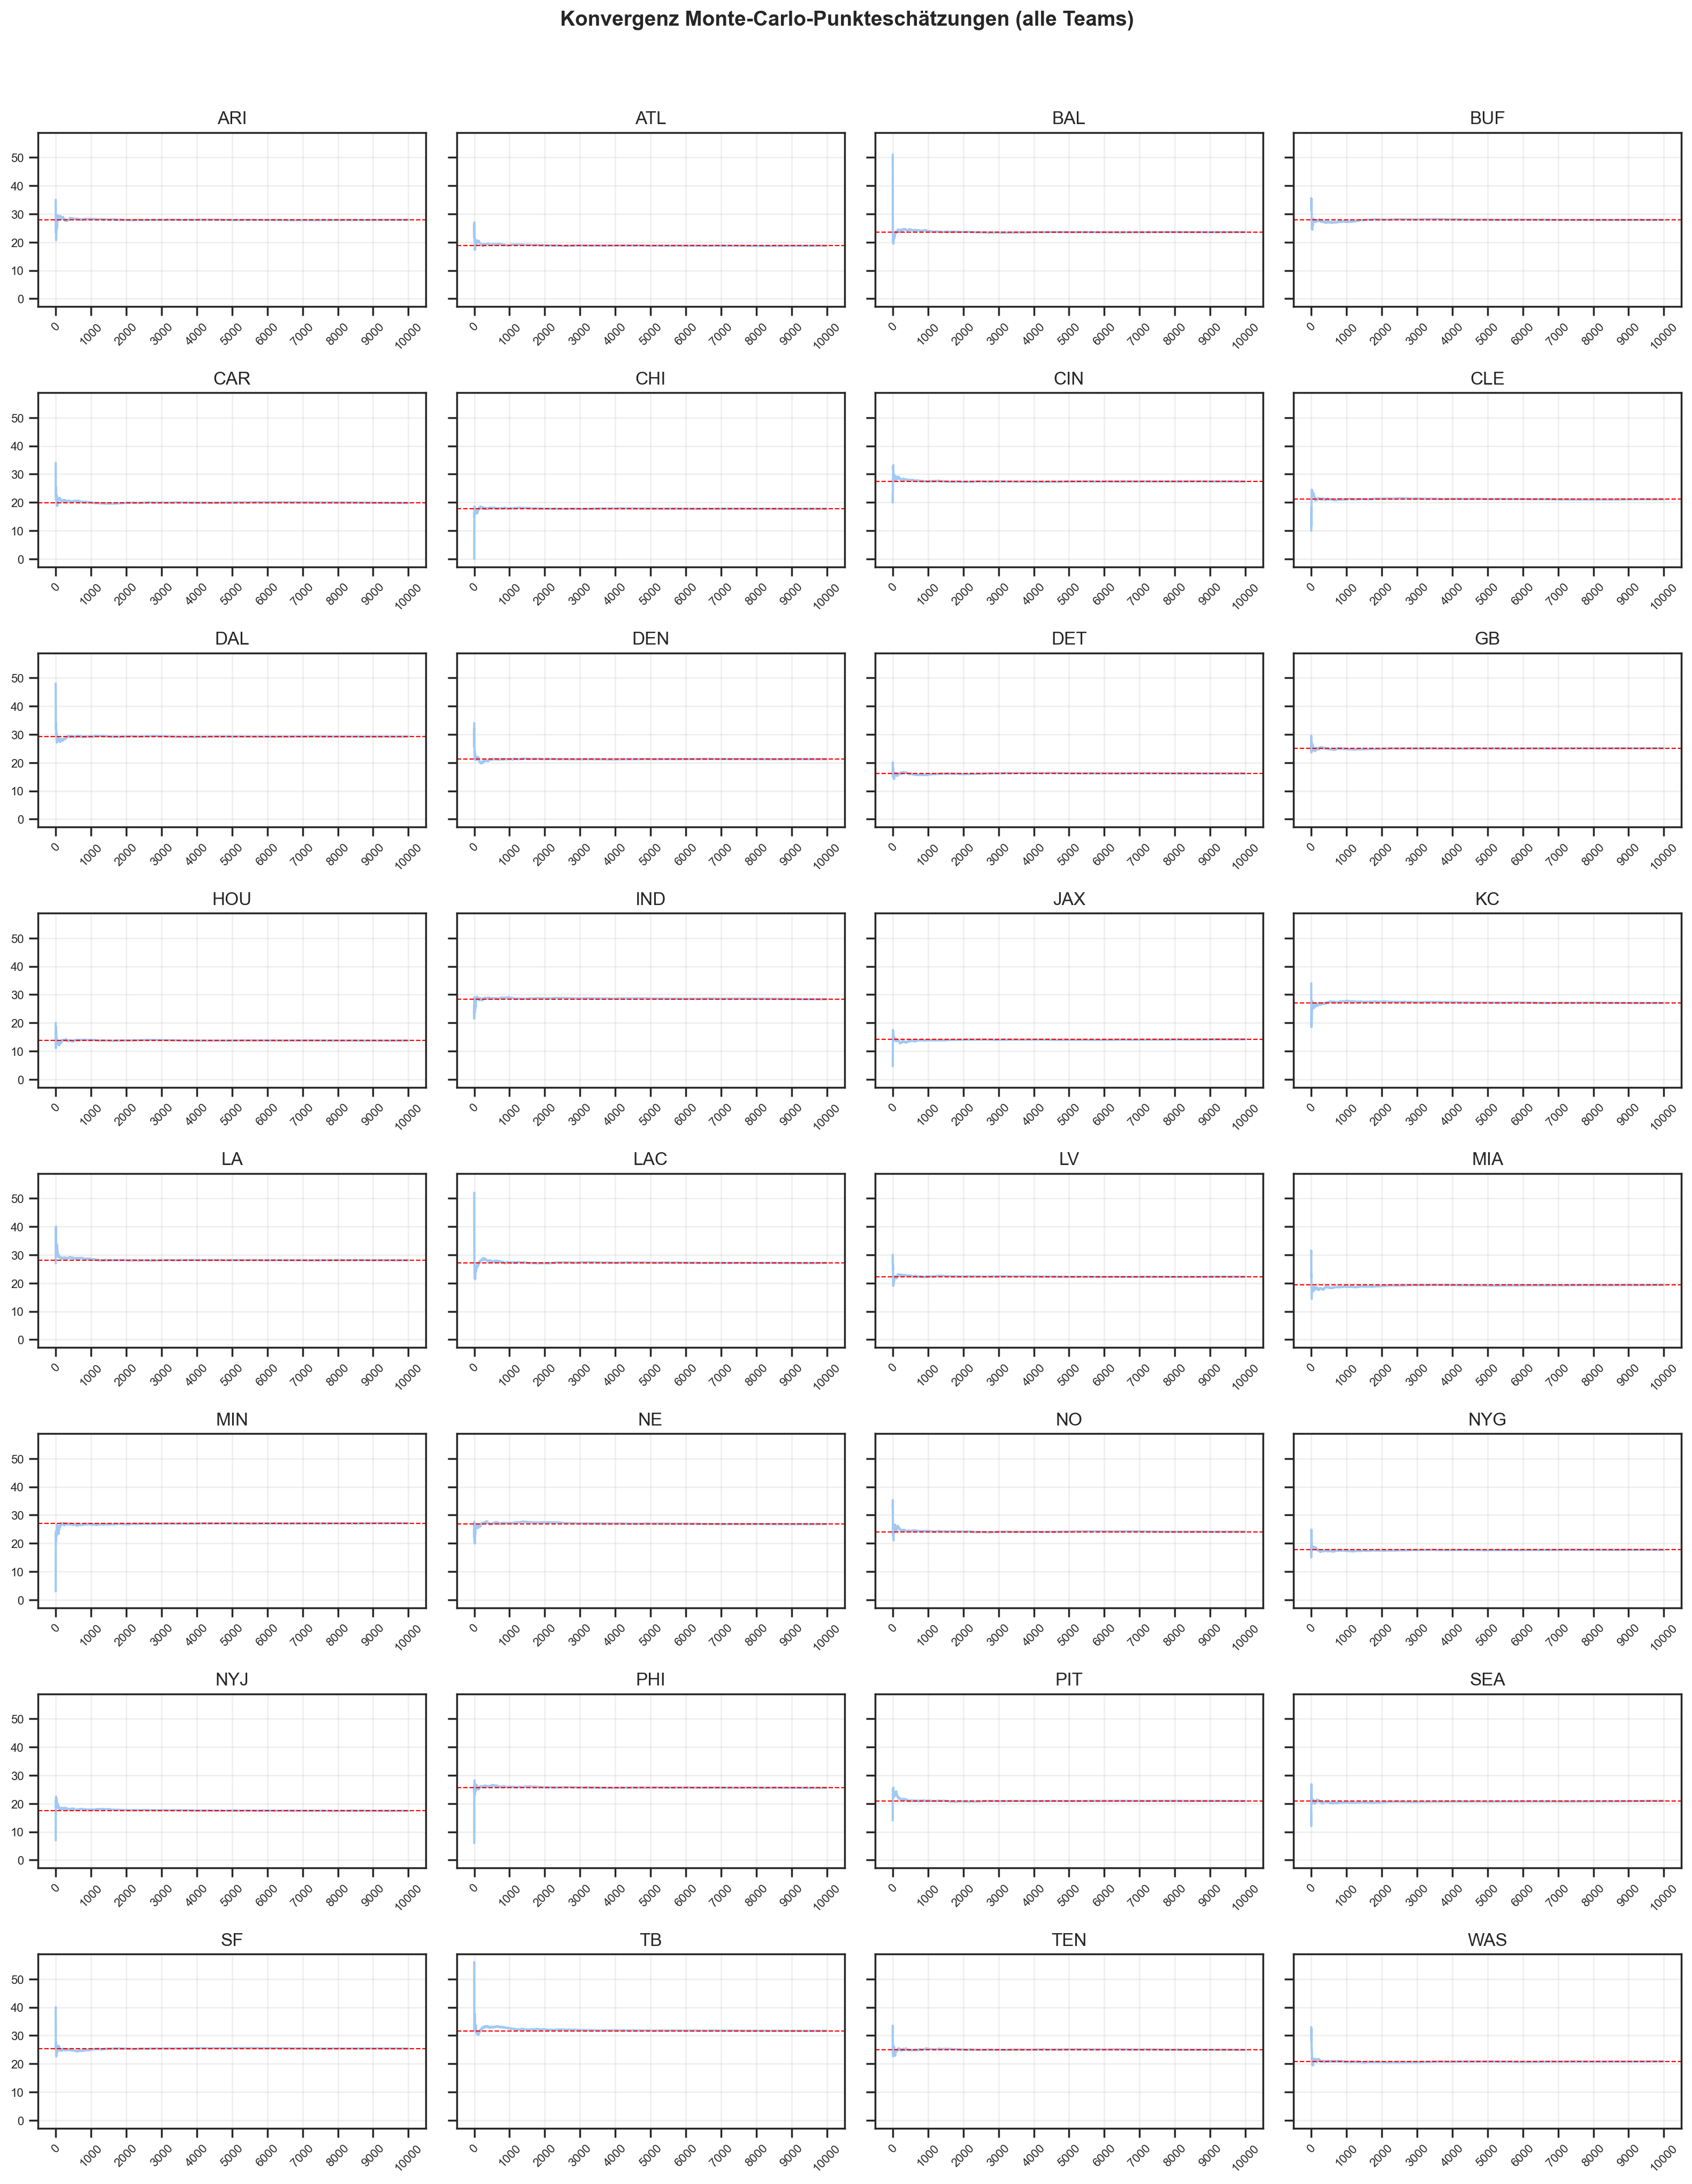

In [22]:
teams = sorted(df_till_w14["team"].unique())
n_teams = len(teams)
n_sims = 10000

# Gridgrösse Subplots
n_cols = 4
n_rows = int(np.ceil(n_teams / n_cols))

xticks = np.arange(0, n_sims + 1, 1000)

# Figure anlegen
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 2.5), sharey=True)
axes = axes.flatten()

for i, team in enumerate(teams):
    # Simulation ausführen
    scores = draw_total(team)
    cum_mean = np.cumsum(scores) / np.arange(1, n_sims + 1)

    # Plot im entsprechenden Subplot
    ax = axes[i]
    ax.plot(cum_mean, label=f"{team}")
    ax.axhline(np.mean(scores), color="red", linestyle="--", linewidth=0.8)
    ax.set_title(team)
    ax.set_xticks(xticks)
    ax.tick_params(axis="x", labelrotation=45)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

# Leere Subplots entfernen
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(
    "Konvergenz Monte-Carlo-Punkteschätzungen (alle Teams)",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

# Ergebnisse

## Punkteabweichung anhand divergent barplot

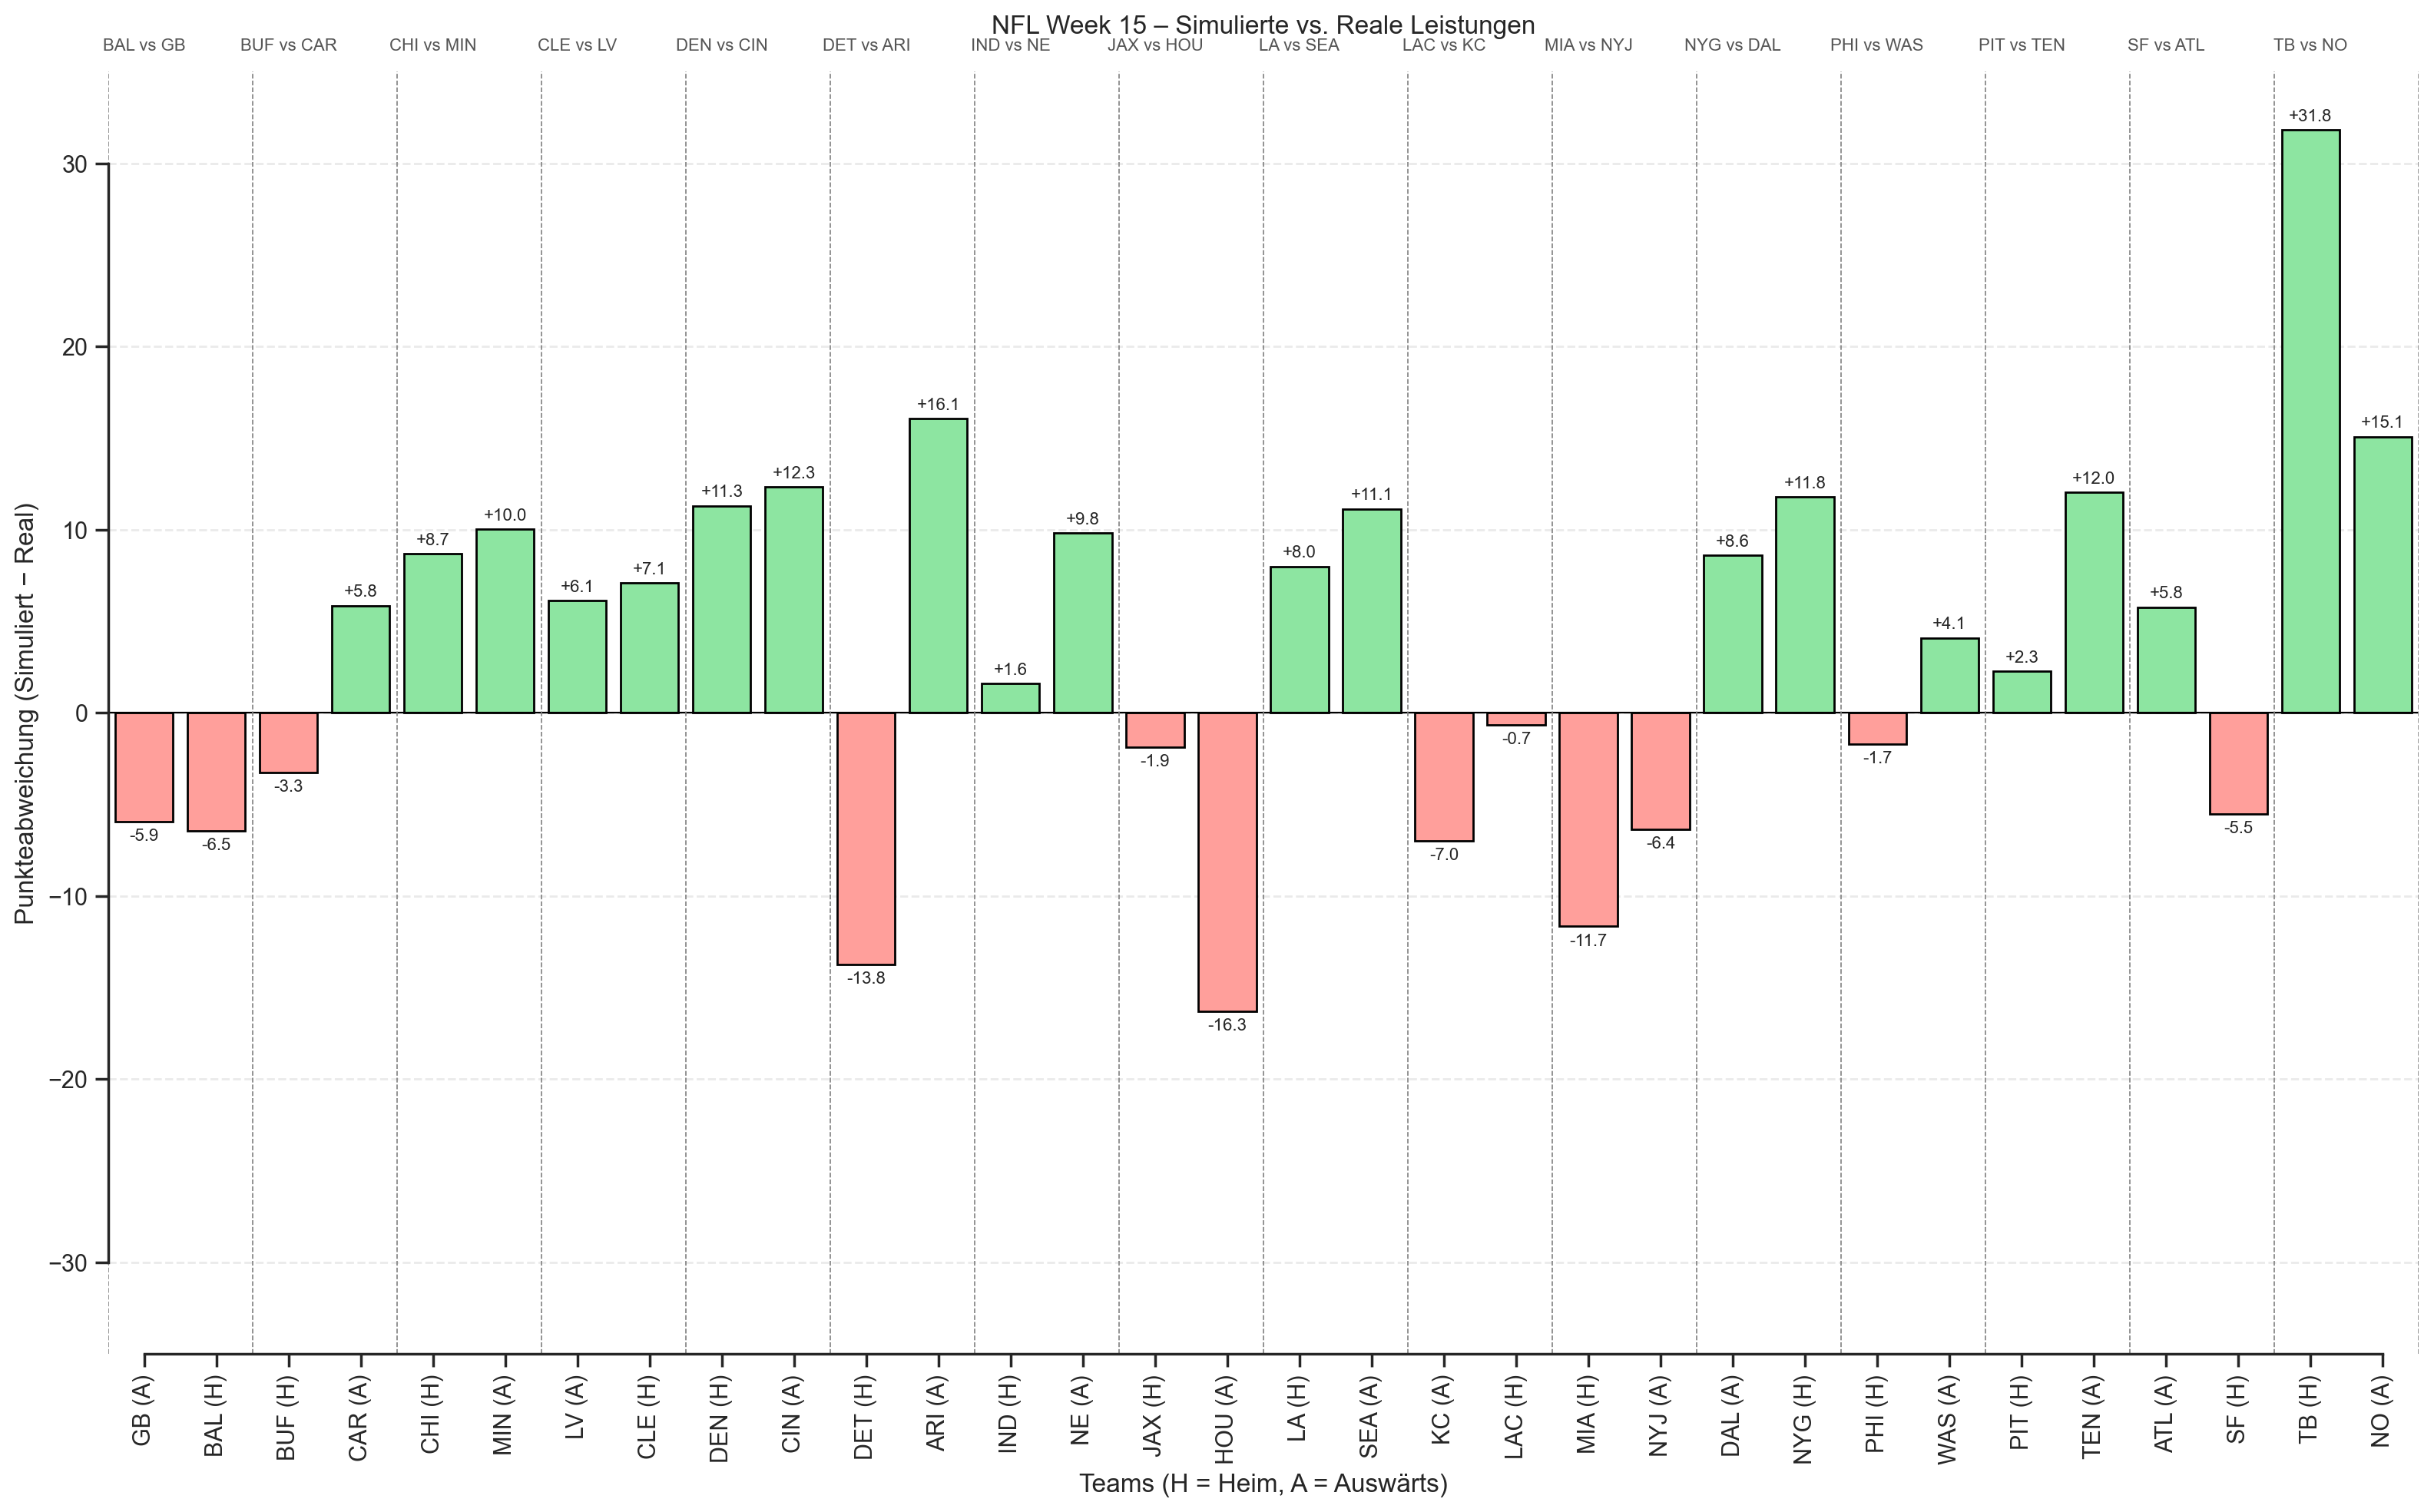

In [23]:
# Seaborn-Stil aktivieren
sns.set_theme(style="ticks", palette="pastel")

# Abweichungen berechnen (Simulation – Realität)
sim_df["deviation_home"] = sim_df["mean_sim_home"] - sim_df["real_home"]
sim_df["deviation_away"] = sim_df["mean_sim_away"] - sim_df["real_away"]

# Einzelne Team-Einträge für Plot aufbereiten (Heim + Auswärts je Spiel)
records = []
for _, row in sim_df.iterrows():
    records.append(
        {
            "team": f"{row['home_team']} (H)",
            "deviation": row["deviation_home"],
            "matchup": f"{row['home_team']} vs {row['away_team']}",
            "sign": "Positiv" if row["deviation_home"] >= 0 else "Negativ",
        }
    )
    records.append(
        {
            "team": f"{row['away_team']} (A)",
            "deviation": row["deviation_away"],
            "matchup": f"{row['home_team']} vs {row['away_team']}",
            "sign": "Positiv" if row["deviation_away"] >= 0 else "Negativ",
        }
    )

# DataFrame für den Plot erzeugen und sortieren
plot_df = pd.DataFrame(records)
plot_df["sort_key"] = plot_df["matchup"] + plot_df["team"].str[-3]
plot_df = plot_df.sort_values("sort_key").reset_index(drop=True)

# Farben definieren für positive und negative Abweichungen
pastel = sns.color_palette("pastel")
pos_color = pastel[2]  # grünlich
neg_color = pastel[3]  # rötlich
colors = plot_df["sign"].map({"Positiv": pos_color, "Negativ": neg_color}).tolist()

# Plot erstellen
fig, ax = plt.subplots(figsize=(16, 10))

# Balken zeichnen (weiß als Basisfarbe)
sns.barplot(
    x="team",
    y="deviation",
    data=plot_df,
    color="white",
    edgecolor="black",
    dodge=False,
    ax=ax,
)

# Balkenfarben manuell setzen
for bar, col in zip(ax.patches, colors):
    bar.set_facecolor(col)

# 5) Achsenbeschriftung, Layout, Styling
ax.axhline(0, color="black", lw=0.8)  # Null-Linie
ax.set_ylabel("Punkteabweichung (Simuliert − Real)")
ax.set_xlabel("Teams (H = Heim, A = Auswärts)")
ylim = plot_df["deviation"].abs().max() * 1.1
ax.set_ylim(-ylim, ylim)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("NFL Week 15 – Simulierte vs. Reale Leistungen", pad=18)
ax.grid(axis="y", linestyle="--", alpha=0.4)
sns.despine(trim=True)

# Abweichungswerte direkt auf die Balken schreiben
for p in ax.patches:
    val = p.get_height()
    if val != 0:
        ax.annotate(
            f"{val:+.1f}",
            (p.get_x() + p.get_width() / 2, val),
            ha="center",
            va="bottom" if val > 0 else "top",
            xytext=(0, 3 if val > 0 else -3),
            textcoords="offset points",
            fontsize=8,
        )

# Vertikale Linien und Matchup-Labels einfügen
prev = ""
for idx, matchup in enumerate(plot_df["matchup"]):
    if matchup != prev:
        ax.axvline(idx - 0.5, color="grey", linestyle="--", lw=0.6)
        ax.text(
            idx,
            ylim + 1,
            matchup,
            ha="center",
            va="bottom",
            fontsize=8,
            color="#555555",
        )
        prev = matchup
# Letzte Trennlinie
ax.axvline(len(plot_df) - 0.5, color="grey", linestyle="--", lw=0.6)

plt.tight_layout()
plt.show()

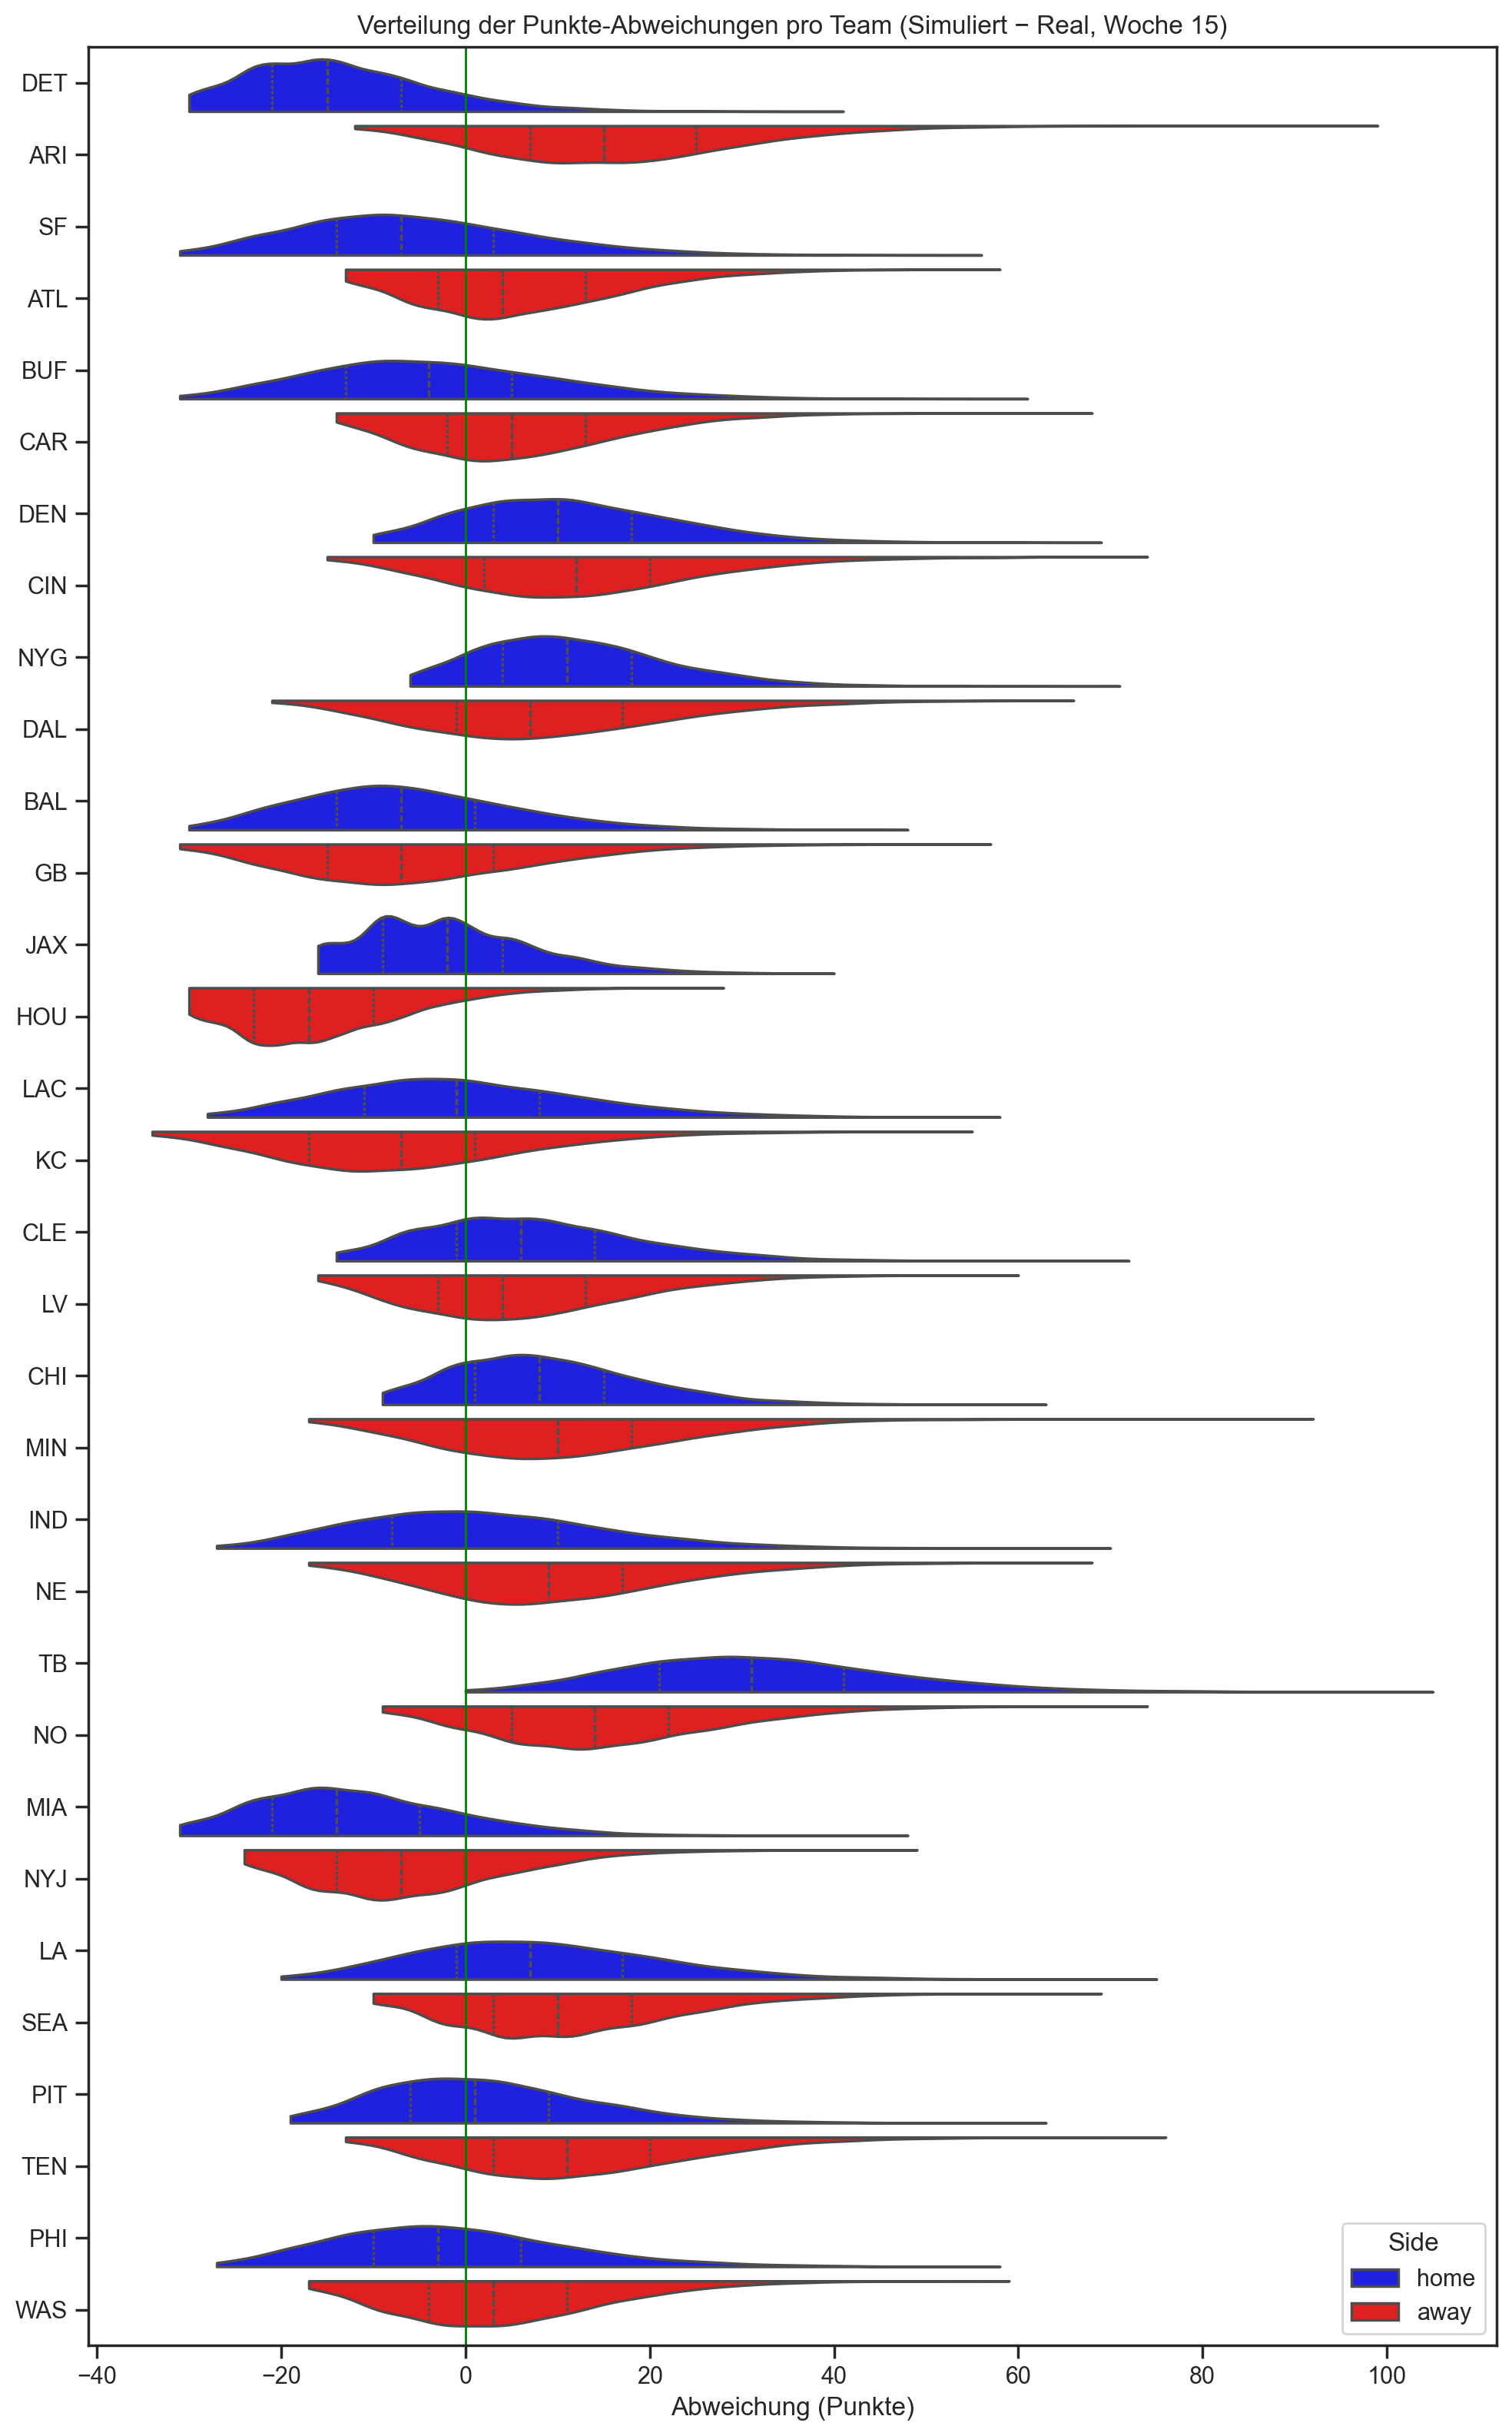

In [24]:
# --- 1) DataFrame mit allen Simulations-Abweichungen aufbauen ---
records = []
for _, game in df_w15.iterrows():
    home, away = game.home_team, game.away_team
    real_home, real_away = game.home_score, game.away_score

    # Simulation draw_total() musst du aus deinem Notebook übernehmen
    total_home = draw_total(home)
    total_away = draw_total(away)

    # Abweichung pro Simulation berechnen
    devi_home = total_home - real_home
    devi_away = total_away - real_away

    # Ergebnisse sammeln
    records += [{"team": home, "side": "home", "deviation": d} for d in devi_home] + [
        {"team": away, "side": "away", "deviation": d} for d in devi_away
    ]

df_violin = pd.DataFrame(records)

# --- 2) Violinplot zeichnen ---
plt.figure(figsize=(10, len(df_violin["team"].unique()) * 0.5))

sns.violinplot(
    x="deviation",
    y="team",
    hue="side",
    data=df_violin,
    split=True,
    orient="h",
    palette={"away": "red", "home": "blue"},
    inner="quartile",  # quartile-Lines inkl. Median
    bw=0.2,
    cut=0,
)

# grüne Mittelachse bei Abweichung=0
plt.axvline(0, color="green", lw=1)

plt.title("Verteilung der Punkte-Abweichungen pro Team (Simuliert − Real, Woche 15)")
plt.xlabel("Abweichung (Punkte)")
plt.ylabel("")
plt.legend(title="Side", loc="lower right")

plt.tight_layout()
plt.show()

### Interpretation 
#### Breite an einer Stelle = Dichte
-   Eine besonders breite Stelle z.B + 5 Punkten bedeutet, dass in vielen der 10'000 Simulationen die Abweichung um +5 lag.

#### Innere Linie (quartile)
-   den Median als durchgezogenen Strich
-   die erste gestrichelte Linie = 1. quartil, die zweite gestrichelte Linie = 2.quartil

#### Ausläufer (Whisker)
-   Die dünnen schwarzen Linien an den Enden zeigen, wie weit Ausreisser-Werte noch reichen

#### Die Grüne Linie
-   Bei 0 markiert den Punkt, an dem Simulation und Realität übereinstimmen.
-   Liegen die Punkte rechts von dieser Linie überschätzt das Modell tendenziell, es sagt zu viele Punkte voraus
-   Liegen die Punkte überwiegend links, unterschätzt es im Mittel

## Summe der Punkteabweichung

In [25]:
# Berechnung der Durchschnittsabweichung
avg_deviation_home = sim_df["deviation_home"].mean()
avg_deviation_away = sim_df["deviation_away"].mean()
gesamt_durchschnitt = (
    sim_df["deviation_home"].mean() + sim_df["deviation_away"].mean()
) / 2

print("Durchschnittliche Abweichung pro Spiel:")
print(f"• Heimteams: {avg_deviation_home:.2f} Punkte")
print(f"• Auswärtsteams: {avg_deviation_away:.2f} Punkte")

# Alternativ: Kombinierte Berechnung aller Abweichungen
all_deviations = pd.concat([sim_df["deviation_home"], sim_df["deviation_away"]])
print("\nKombinierte Durchschnittsabweichung aller Teams:")
print(f"{all_deviations.mean():.2f} Punkte")

Durchschnittliche Abweichung pro Spiel:
• Heimteams: 2.34 Punkte
• Auswärtsteams: 5.08 Punkte

Kombinierte Durchschnittsabweichung aller Teams:
3.71 Punkte


# Fazit
Das Modell zeigt insgesamt eine relativ gute Treffsicherheit bei der Vorhersage der Punkteverteilung, was auf die fundierte Grundlage der Monte-Carlo-Simulation mit **realen Verteilungen der Spielstatistiken** (TDs, Field Goals, etc.) zurückzuführen ist. Die durchschnittlichen Abweichungen von ca. **2,29 Punkten bei Heimteams** und ca. **5,04 Punkten bei Auswärtsteams** (**kombiniert ca. 3,66 Punkte**) deuten darauf hin, dass die simulierte Punktzahl im Mittel **nah an der Realität liegt**. Dies unterstreicht die Eignung des gewählten statistischen Ansatzes für die Prognose von Spielverläufen.

Ein zusätzlicher Vorteil des gewählten Vorgehens liegt in der hohen Replizierbarkeit und Transparenz des Modells: Alle verwendeten Wahrscheinlichkeitsverteilungen sind explizit parametrisiert und pro Team gespeichert, sodass jede Simulation nachvollziehbar ist. Diese strukturelle Klarheit verleiht dem Modell wissenschaftliche Strenge und würde auch zukünftige Erweiterungen ermöglichen.

Allerdings zeigen sich bei der **Vorhersage der Gewinnerteams teilweise grössere Abweichungen**. Diese sind vermutlich auf Faktoren zurückzuführen, die in der Simulation nicht abgebildet werden können:
- Unvorhersehbare Ereignisse wie Verletzungen, taktische Anpassungen oder Wetterbedingungen
- Psychologische Einflüsse (z. B. Teamdynamik, Druck in Schlüsselmomenten)
- Die Tatsache, dass bereits kleine Abweichungen in der Punktprognose das Ergebnis umkehren können (insbesondere bei knappen Spielen).

Interessant ist der deutliche Unterschied zwischen Heim- und Auswärtsabweichungen: Während **Heimteams präziser prognostiziert werden**, besteht bei Auswärtsteams grösserer Optimierungsbedarf. Dies könnte auf einen stärkeren **"Home Advantage"-Effekt** hindeuten, der im Modell nicht erfasst wird. 

## Gewinnwahrscheinlichkeit und tatsächlicher Gewinner anhand divergent barplot

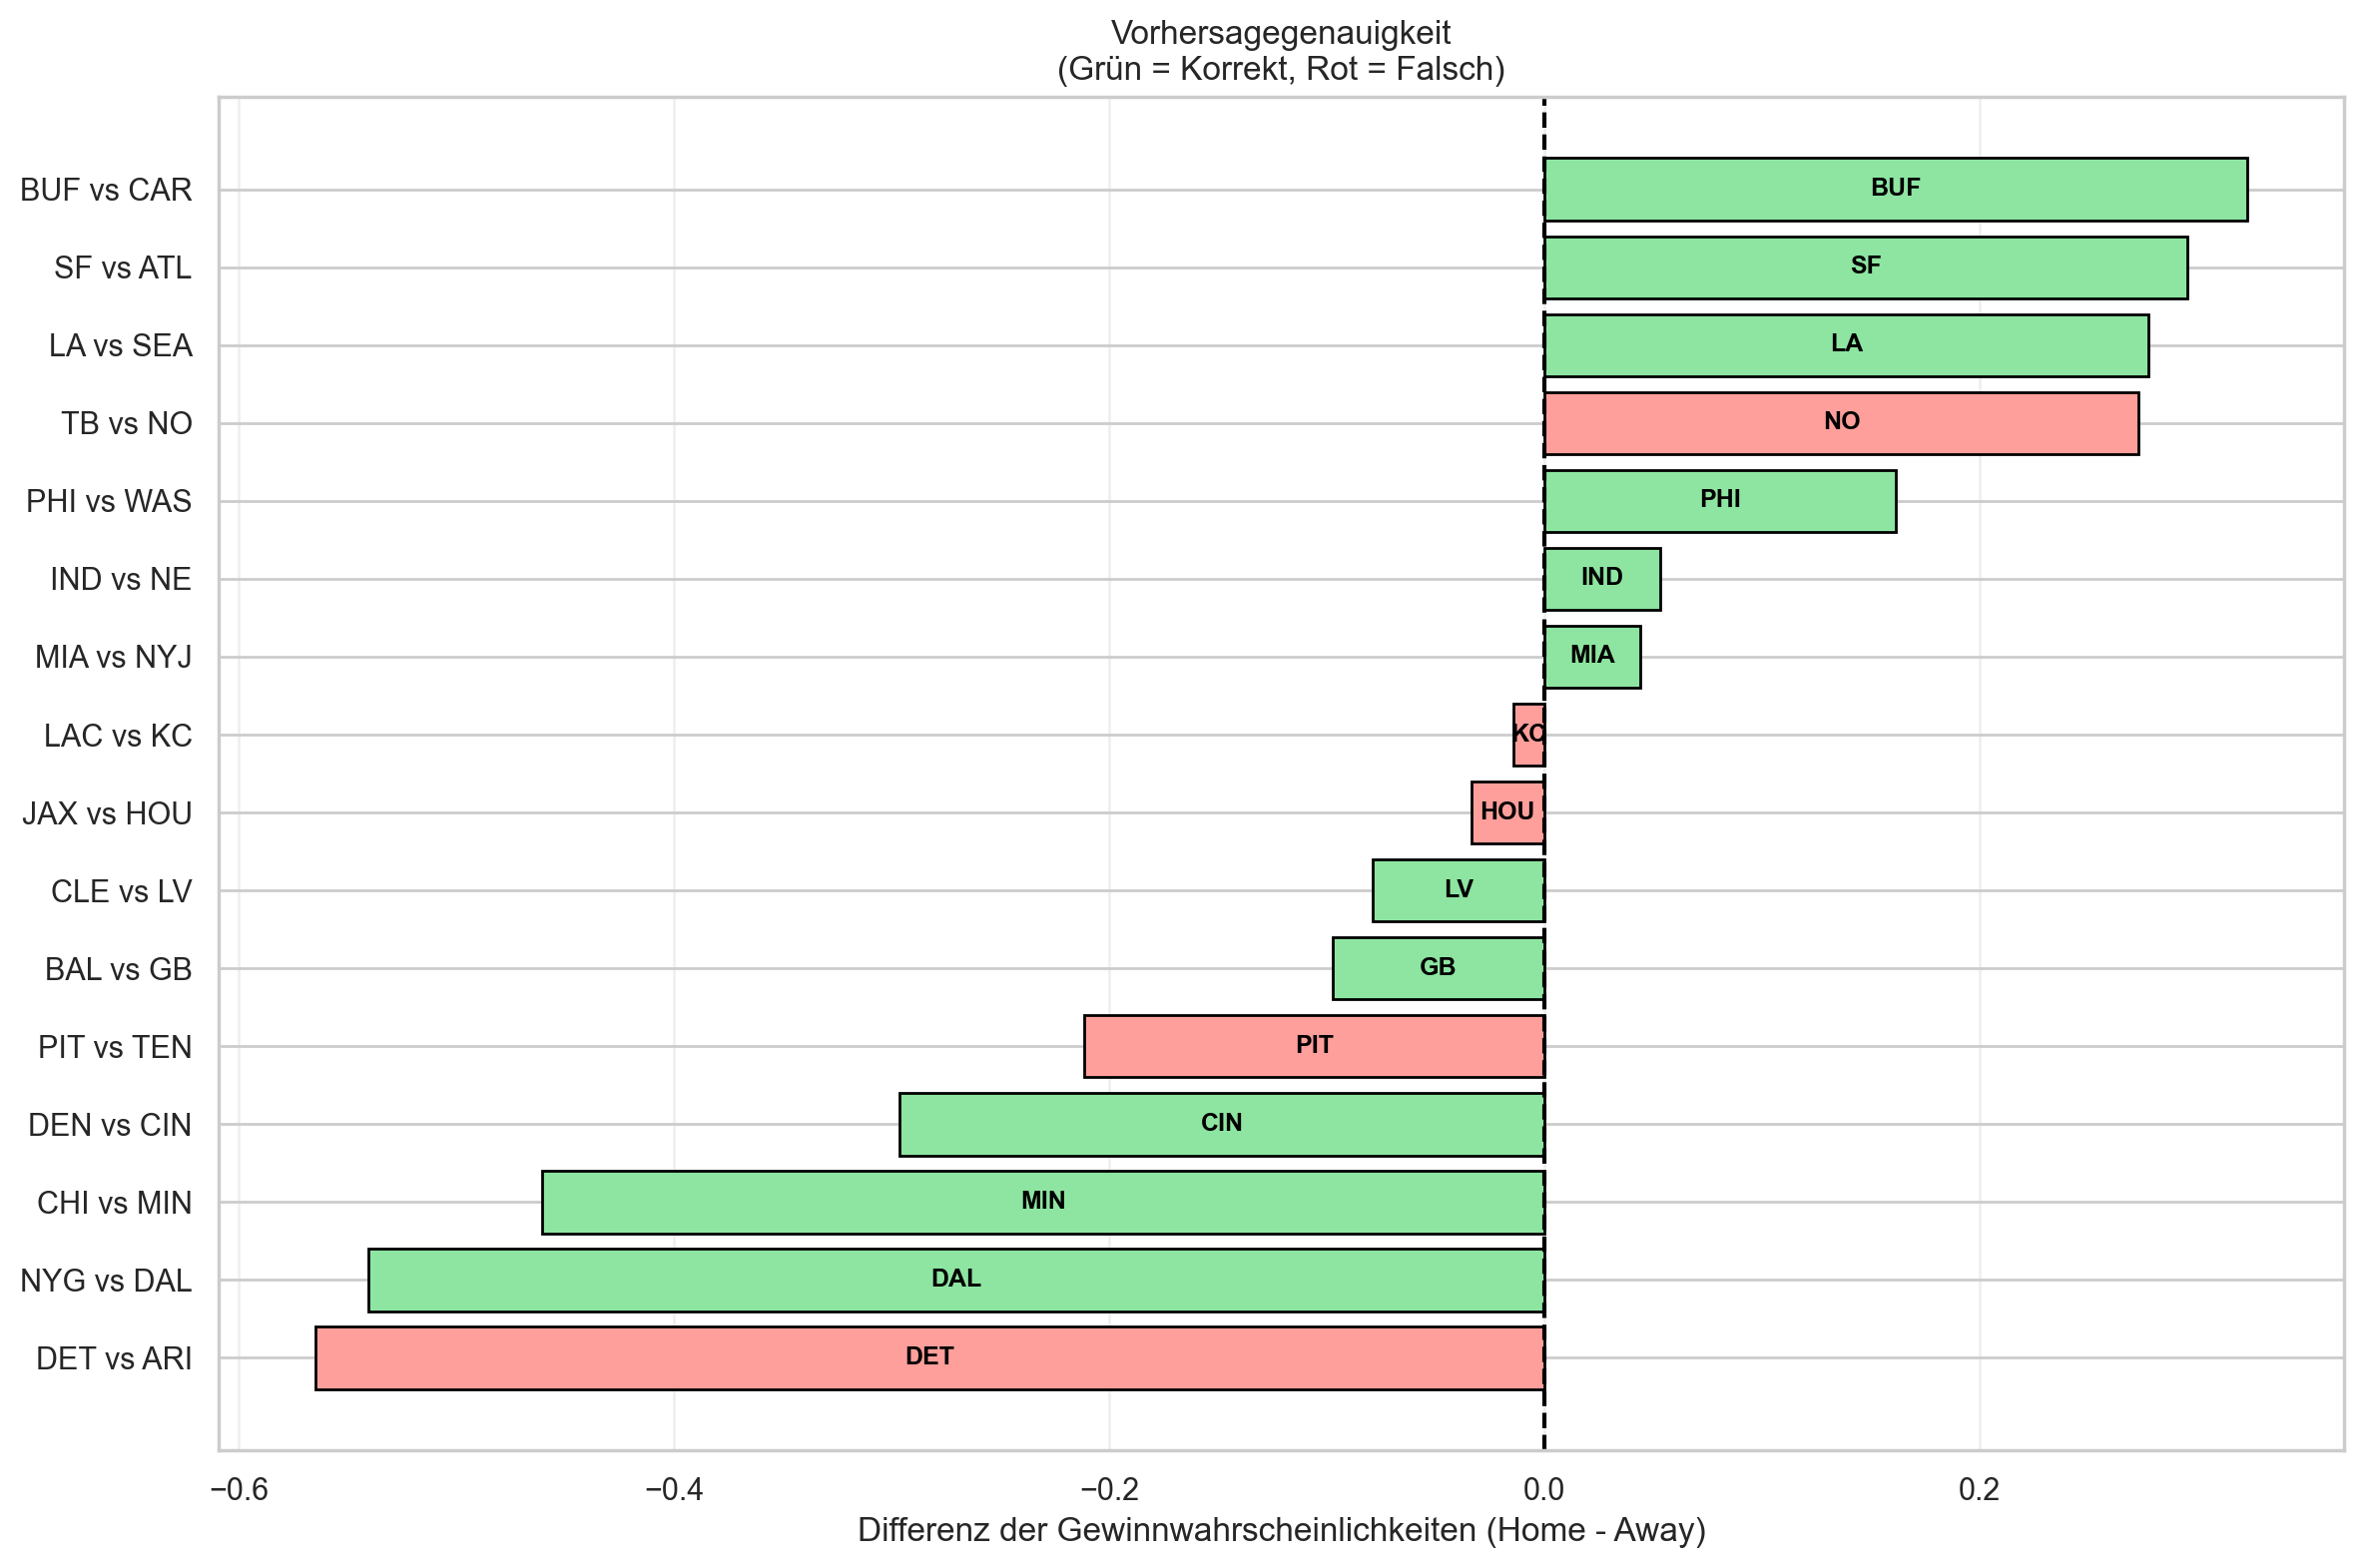

In [26]:
# Seaborn-Stil & Farben aktivieren
sns.set_theme(style="whitegrid", palette="pastel")
pastel = sns.color_palette("pastel")
correct_color = pastel[2]  # grünlich
incorrect_color = pastel[3]  # rötlich

# Differenz berechnen und sortieren
sim_df["prob_diff"] = sim_df["p_home_win"] - sim_df["p_away_win"]
sim_df["correct"] = sim_df["predicted_winner"] == sim_df["actual_winner"]
sim_df_sorted = sim_df.sort_values("prob_diff")

# Farben anhand Korrektheit zuweisen
colors = (
    sim_df_sorted["correct"].map({True: correct_color, False: incorrect_color}).tolist()
)

# Plot erstellen
plt.figure(figsize=(12, 8))
bars = plt.barh(
    sim_df_sorted["home_team"] + " vs " + sim_df_sorted["away_team"],
    sim_df_sorted["prob_diff"],
    color=colors,
    edgecolor="black",
)

# Mittellinie
plt.axvline(0, color="black", linestyle="--")

# Achsenbeschriftungen und Titel
plt.xlabel("Differenz der Gewinnwahrscheinlichkeiten (Home - Away)")
plt.title("Vorhersagegenauigkeit\n(Grün = Korrekt, Rot = Falsch)")
plt.grid(axis="x", alpha=0.3)

# Beschriftungen in den Balken
for bar, actual in zip(bars.patches, sim_df_sorted["actual_winner"]):
    plt.text(
        bar.get_width() / 2 + bar.get_x(),
        bar.get_y() + bar.get_height() / 2,
        actual,
        ha="center",
        va="center",
        color="black",
        fontweight="bold",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

## Fazit bezüglich der Gewinnwahrscheinlichkeit

#### ARI vs. DET (Week 15)  
Das Spiel zwischen den **Detroit Lions (DET)** und **Arizona Cardinals (ARI)** in der 15. Woche verdeutlicht die Grenzen und Stärken statistischer Modelle in der NFL. Trotz einer deutlichen **Gewinnwahrscheinlichkeitsdifferenz von 57% für ARI** gewann DET überraschend mit **30:12**. Dieses Ergebnis wirft Fragen auf und zeigt, wie unvorhersehbare Faktoren die Prognosen beeinflussen können.

#### **Zusammenfassung der Prognose vs. Realität**  
- **Modellvorhersage**: ARI (10-4 Saison, starke Away-Performance) wurde als klarer Favorit gesehen.  
- **Realität**: DET (2-11-1 Saison) dominierte das Spiel trotz schwacher Statistiken.  
- **Entscheidende Abweichung**: Verletzungen von **DeAndre Hopkins (WR)** sowie taktische Fehler der Cardinals waren im Modell nicht abgebildet.  

#### 1. **Verletzungen & Personalsituation**  
- **Kyler Murray**:  
  - Schwache Leistung (3 Rushing Yards, 1 INT, Passer Rating 72.9) → wurde im 4. Quarter durch Colt McCoy ersetzt.  
  - *"They were hungrier than us. They played harder than us."* (Murray nach dem Spiel)  
- **DeAndre Hopkins**: ARI's Top-Receiver fehlte komplett (IR-Liste).  
- **DETs Defense**: Aggressive Strategie gegen Murray:  
  > *"We played aggressively against him and we hit him, and I think you saw the result of that."*  
  > – *Coach Dan Campbell*  

#### 2. **Psychologische Faktoren**  
- **ARI unterschätzte DET**:  
  - *"We didn't come prepared at all and it showed."* (Murray)  
  - Kommentar von Fans:  
    > *"Never underestimate your opponent... looks like the Cardinals did just that!"*  
- **DETs mentale Stärke**:  
  - *"This is what we knew we could do."* (Jared Goff, 3 TDs, 216 Pass-Yards)  

#### 3. **Historische Dynamik**  
- Seit 2015 ist DET gegen ARI dominant (**4-1-1** in den letzten 6 Spielen).  
- **Underdog-Effekt**:  
  > *"This is why I love the NFL. [...] Great effort by the Lions to show their fangs."*  
  > – *Fan-Kommentar*  

#### 4. **Taktische Schwächen von ARI**  
- **Zögerliche Entscheidungen**:  
  - Verzicht auf 4th Downs (z. B. 4th-and-3 im 3. Quarter).  
  - *"They had a better sense of urgency from the start."* (Coach Kliff Kingsbury)  
- **Defensive Lücken**: DETs Craig Reynolds (112 Rushing Yards) und Amon-Ra St. Brown (90 Receiving Yards) dominierten.  

---

#### **Implikationen für das Modell**  

| **Stärken** ✅                          | **Schwächen** ⚠️                          |
|----------------------------------------|------------------------------------------|
| Basierend auf statistischen Verteilungen (TDs, Field Goals). | Keine Berücksichtigung von Verletzungen oder Teamdynamik. |
| Langfristige Trends (Saison-Records) werden korrekt gewichtet. | Momentum-Shifts (z. B. frühe Field Goals von DET) schwer modellierbar. |

> **Lektion aus Week 15**:  
> *"Never underestimate your opponent"* – selbst das beste Modell kann menschliche Unberechenbarkeit nicht vollständig antizipieren.  

# Schlusswort
Das hier entwickelte Modell zur NFL-Punktprognose auf Basis empirischer Wahrscheinlichkeitsverteilungen bietet eine solide Grundlage zur Simulation realistischer Spielverläufe. Es zeigt eindrucksvoll, wie sich datenbasierte Modellierung mit Sportverständnis kombinieren lässt. Trotz einzelner Limitierungen, insbesondere im Hinblick auf nicht messbare Faktoren, liefern die Simulationen wertvolle Einblicke und bieten zahlreiche Ansatzpunkte für weiterführende Analysen.

# Anhang

## Quellenverzeichnis
1. **DataCamp – Vinod Chugani**  
   - [Poisson-Verteilung: Ein umfassender Leitfaden](https://www.datacamp.com/de/tutorial/poisson-distribution)  
   *(Poisson- und Negative Binomialverteilung)*
   *(Zugriff am: 22.04.2025)*

2. **Medium – E. Taskesen**  
   - [How to Find the Best Theoretical Distribution for Your Data](https://medium.com/data-science/how-to-find-the-best-theoretical-distribution-for-your-data-a26e5673b4bd)  
   *(Sum of Squared Errors (SSE))*
   *(Zugriff am: 21.05.2025)*

3. **Medium – C. Hanyang**  
   - [Introduction to Zero-Inflated Model](https://chenghanyang728.medium.com/introduction-to-zero-inflated-model-875537d9ebbb)  
   *(Zero-Inflated Models (ZIP und ZINB))*
   *(Zugriff am: 22.04.2025)*

4. **AS - P. Rudder**  
   - [What is the two-point conversion success rate in the NFL?](https://en.as.com/nfl/what-is-the-two-point-conversion-success-rate-in-the-nfl-history-and-strategy-behind-the-play-n/)   
   *(Erfolgsquote für PATs und 2-Point Conversions)*
   *(Zugriff am: 21.05.2025)*

5. **ESPN – NFL Nation (Blog)**  
   - [How the NFL's PAT rule changed the game (or didn't)](https://www.espn.com/blog/nflnation/post/_/id/194618/how-the-nfls-pat-rule-changed-the-game-or-didnt)  
   *(Statistische Entwicklung von PAT- und 2PC-Erfolgen)*
   *(Zugriff am: 22.04.2025)*

6. **ESPN – AP**  
   - [Spielzusammenfassung (ESPN)](https://www.espn.com/nfl/recap?gameId=401326544)  
   *(Spielzusammenfassung ARI vs DET)*
   *(Zugriff am: 22.04.2025)*

7. **Youtube – NFL**  
   - [Highlight-Video (YouTube)](https://www.youtube.com/watch?v=wag22BhMKjQ)   
   *(Highlight-Video (YouTube) und Kommentare)*
   *(Zugriff am: 22.04.2025)*

8. **Two-Point Conversion – Wikipedia**  
   - [Two-Point Conversion](https://de.wikipedia.org/wiki/Two-Point_Conversion)   
   *(Versuchsquote für PATs und 2-Point Conversions)*
   *(Zugriff am: 21.05.2025)*

9. **Datensatz - NFL**  
   - [nflreadr](https://nflreadr.nflverse.com/)  
   *(15 Spielwochen vom Jahr 2021)*
   *(Zugriff am: 04.03.2025)*
